# Import packages

Preparation and figures for article 

In [10]:
from star import *
import glob

In [97]:
# Other functions to be used that are not in the package (yet?):

def merge_energies_lc(lc_v):
    """
    Merge light curves of different energies with each other.
    
    **Parameter**:
    
    ``lc_v``: list of lightcurve objects   
        Light curves to be merged.
        
    **Return**:
    
    ``lc_broad``: lightcurve object   
        The merged light curve, now spanning a larger energy range.
    """
    
    
    assert len(lc_v) >= 2, 'You need at least two light curves to be merged.'
    
    # Create a new light curve object
    lc_broad = lightcurve('')
    
    # Initilaize 
    print('Initializing with lc in {}-{} keV'.format(lc_v[0].Emin,lc_v[0].Emax))
    lc_broad.rate = np.copy(lc_v[0].rate)
    lc_broad.err = np.copy(lc_v[0].err)
    lc_broad.N = np.copy(lc_v[0].N)
    lc_broad.dt = np.copy(lc_v[0].dt)
    lc_broad.t = np.copy(lc_v[0].t)

    # Merge with the rest
    for i in range(1,len(lc_v)):
        print('Merging with lc in {}-{} keV'.format(lc_v[i].Emin,lc_v[i].Emax))
        assert lc_v[i].Emin >= lc_v[i-1].Emax, "No overlapping energy bands allowed"
        lc_broad.rate += lc_v[i].rate
        lc_broad.err = np.sqrt(lc_broad.err**2+lc_v[i].err**2)
            
    # Update again 
    lc_broad.R = np.mean(lc_broad.rate)
    lc_broad.Emin = lc_v[0].Emin
    lc_broad.Emax = lc_v[-1].Emax
    
    #lc_broad.err = np.sqrt(lc_broad.rate/lc.dt)

    return lc_broad

def split_time_lc(lc,equal=True,m=None,step=None,i=None,start=None,stop=None):
    """
    Split light curve into several shorter parts.
    
    **Parameters**:
    
    ``equal``: boolean, default, True
        If true, split light curve into equally long parts.
        If false, split light curve according to start and stop indices. 
        
    ``m,step,i``: ints
        Bins per segment, segments per part and part number respectively.
    
    ``start,stop``: ints
        Index for start and stop of the part.
        
    **Return**:
    
    ``lc_part``: lightcurve object   
        A part of the original light curve. 
    """
    
    if equal:
        start, stop = i*m*step, (i+1)*m*step
    
    print('New part for time indices: ({})-({})'.format(start,stop))
    
    lc_part = copy.deepcopy(lc)
    lc_part.t = lc_part.t[start:stop]
    lc_part.rate = lc_part.rate[start:stop]
    lc_part.err = lc_part.err[start:stop]
    lc_part.R = np.mean(lc_part.rate)
    lc_part.N = len(lc_part.t)

    return lc_part

def find_where_to_split_lc(lc_v,stops,m=2**13):
    """
    If want to split up an observation in several parts.
    
    Needs to be updated: should just need to input one lightcurve, not a list.
    
    **Parameters**:
    
    ``lc_v``: list of light curve objects.
        The lightcurves to be split., 
        
    **Returns**:
    
    ``start_v,stop_v``: list of arrays
        Vectors containing the indices for start and stop for each part.   
    """
    
    ax = standard_plot()
    plt.plot(lc_v[0].t,lc_v[0].rate)
    N = lc_v[0].N

    stops.append(lc_v[0].t[-1]) #the last part
    start = 0
    
    # Determine where to split parts
    break_points = []
    len_of_parts = []
    for stop in stops:
        part = [t for t in lc_v[0].t if start < t < stop]
        ax.axvline(part[-1],color='r',label='end of a part')
        break_points.append(np.where(lc_v[0].t == part[-1])[0][0])
        
        start = stop
        
        len_of_parts_temp = len(part)/m
        len_of_parts.append(len_of_parts_temp)
        print('\nLength of part: ',len_of_parts_temp)
    
    # Determine start and stop for each part
    
    break_points.insert(0,0)
    
    start_v = []
    stop_v = []
    for i in range(0,len(break_points)-1):
        #if len_of_parts[i] >= 10:
        start_v.append(break_points[i])
        stop_v.append(break_points[i+1])

    return start_v, stop_v 

def print_datetime_UT(lc_v,obs_start,stops):
    """
    If want to split up an observation in several parts, each of length m*step bins, 
    where m=bins/seg and step = num of seg.
    
    **Parameters**:
    
    ``obs_start``: str, 
        Format: YYYY-MM-DDThh:mm:ss.sss 
    """
    
    obs_time = dati.fromisoformat(obs_start)
    print('obs start time = ',obs_time,'\n')
    
    print('The different parts are:')
    
    start = 0
    for stop in stops:
    
        time_change_to_start = datetime.timedelta(seconds=start)
        time_change_to_end = datetime.timedelta(seconds=stop)
        
        part_start = obs_time + time_change_to_start
        part_end = obs_time + time_change_to_end
        
        print(str(part_start.isoformat(sep='T', timespec='milliseconds'))+',',part_end.isoformat(sep='T', timespec='milliseconds'))

        start = stop
        
def plot_power(ps_v,mi_v,ma_v,color):
    
    ax = standard_plot(h=8)
    for i in range(0,len(ps_v)):
        plt.subplot(3,1,i+1)
        ax = plt.gca()
        mi,ma = mi_v[i],ma_v[i] #min and max 
        ax.axvspan(mi,ma,color='gray',alpha=0.2)
        ax.axvspan(mi*2,ma*2,color='gray',alpha=0.2)
        ps = ps_v[i]
        ps.rebin(num=200)
        ps.plot(first=0,show=0,color=color)
        if i==0 or i==2 or i==4:
            plt.ylabel('Freq x Power') # P_f in [(RMS/Average)$^2$/Hz]
        if i>2:
            ax.set_xlabel('Frequency (Hz)')
        else:
            ax.set_xlabel(' ')
        plt.legend(fontsize=12)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
    plt.tight_layout()
    plt.show()

# plot_power(ps_verysoft_parts,[1.6,1.6,1.7],[2,2,2.2],'r')

def power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num,save='None',third=False,lw=1,w=10):
    """
    With 2 time lag plots... 
    
    ps: power spectrum object
    
    ttimelag_vsh = [x0_vsh,t0_vsh,d0_vsh]l: time_lag, as [x,tau,tau_err]
    
    Change to:
    > filenames with data as: 
    data = [x,ps_vs_save,ps_s_save,ps_h_save,timelag_vsh,timelag_sh]
    
    x = frequency vector (same for all ps)
    ps_vs_save = [ps_vs.fft_rate, ps_vs.fft_rate_err, ps_vs.Emin, ps_vs.Emax] #very soft 
    ps_s_save = [ps_s.fft_rate, ps_s.fft_rate_err, ps_s.Emin, ps_s.Emax] #soft 
    ps_h_save = [ps_h.fft_rate, ps_h.fft_rate_err, ps_h.Emin, ps_h.Emax] #hard
    timelag_vsh = [x0_vsh,t0_vsh,d0_vsh]
    timelag_sh = [x0_sh,t0_sh,d0_sh]
    """
    
    from matplotlib import rc
    rc('font',**{'family':'serif','serif':['Palatino']})
    plt.rcParams['pdf.fonttype'] = 42
    
    fig = plt.figure(figsize=(w,6))
    plt.rcParams.update({'font.size': 11})
    gs = fig.add_gridspec(nrows=16,ncols=len(filenames),hspace=0,wspace=0.1)
    
    for i,f in enumerate(filenames):
        
        # Variables
        color,mi,ma = color_v[i],mi_v[i],ma_v[i]  
        print('Loading from ',f)
        [x,ps_vs_save,ps_s_save,ps_h_save,timelag_vsh,timelag_sh] = np.load(f,allow_pickle=True)    
        
        # Initialize col i
        ax0 = fig.add_subplot(gs[0:6,i])
        ax1 = fig.add_subplot(gs[6:11,i],sharex=ax0)
        ax2 = fig.add_subplot(gs[11:16,i],sharex=ax0)

        # Do for both subplots
        for ax in [ax0,ax1,ax2]:
            ax.label_outer()
            ax.set_xscale('log')
            if mi != ma:
                scale = 1
                ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
                ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
                if third == True:
                    ax.axvspan(mi*3,ma*3,color='lightgray',alpha=0.7)
            else:
                scale = 0.25
            ax.tick_params(which='minor',length=2,width=0.7)
            ax.tick_params(which='major',length=4,width=0.7)

        # Fix axis 0 
        plt.sca(ax0)
        Emin_v, Emax_v = [], []
        for ps,alp in zip([ps_h_save,ps_s_save,ps_vs_save],[0.5,0.75,0.99]):
            
            p,p_err,Emin,Emax = ps[0],ps[1],ps[2],ps[3]
            
            Emin_v.insert(0,Emin)
            Emax_v.insert(0,Emax)
            
            molb, fPf, fPferr = log_rebin(x, p*x, p_err*x, num=int(num*scale))
            
            label = '{}-{} keV'.format(Emin,Emax)
            ax0.step(molb, fPf, where='mid',color=color,label=label,alpha=alp,linewidth=lw)
            ax0.errorbar(molb, fPf, fPferr, fmt=',',color=color,elinewidth=1,alpha=alp,linewidth=lw)
            
            # Also good spot to place text:

        if i == 0:
            plt.legend(frameon=False,loc='lower left',fontsize=8)
        else:
            ax0.text(0.2,0.9,'QPO = ',fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
            ax0.text(0.3,0.82,'${} \pm {:.2f}$'.format(np.mean([mi,ma]),(ma-mi)/2),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
        
        plt.title(titles[i],loc='left',fontsize=10,fontweight="bold")
        ax0.set_xscale('log')
        ax0.set_yscale('log')
        ax0.set_xlim(x[0],x[-1]) # fix x-limits of axis so that the following don't mess it up
        #ax0.set_ylim(0.0004,0.006) # fix x-limits of axis so that the following don't mess it up
        ax0.tick_params(axis='x',which='both',direction='inout')
        ax0.tick_params(axis='y',which='both',direction='in')
        ax0.tick_params(which='minor',length=2,width=0.7)
        ax0.tick_params(which='major',length=4,width=0.7)
        ax0.zorder = 1 #to make ticks visible 
        
        # Fix axis 1
        for ax,tl in zip([ax1,ax2],[timelag_vsh,timelag_sh]):
            x0,t0,d0 = tl 
            x,t,d = log_rebin(x0,t0,d0,num=int(num*scale))
            ax.step(x,-t,color,where='mid',linewidth=lw)
            ax.errorbar(x,-t,yerr=d,fmt='.',color=color,markersize=0,capsize=0,linewidth=lw)
            ax.tick_params(which='both',direction='in')
            ax.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
            ax.set_xlabel('Freq (Hz)')
            ax.set_yscale('symlog', linthresh=0.001)
            if i == 0:
                ax.text(0.5,0.2,'({}-{} keV) vs.'.format(Emin_v.pop(0),Emax_v.pop(0)),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.text(0.55,0.12,'({}-{} keV)'.format(Emin_v[-1],Emax_v[-1]),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        ax0.set_ylim(bottom=0.0002)
        ax0.set_xlim([0.05,25])
        ax1.set_xlim([0.05,25])
        ax2.set_xlim([0.05,25])
        
        if i == 0:
            ax0.set_ylabel('Power $\cdot$ Freq')
            ax1.set_ylabel('Time Lag (s)')
            ax2.set_ylabel('Time Lag (s)')

    if save != 'None':
        print('Saving: ',save)
        plt.savefig(save,bbox_inches='tight',format="pdf") 
    
    plt.show()
    
    
def save_for_hardness_map(obs_id,lc_v,start_v,stop_v,obj='MAXIJ1535'):
    """Save counts_2to7 etc for all individual parts of an observation."""
    
    count = 1
    for start,stop in zip(start_v,stop_v):
        
        lc_v_temp = []
        for lc in lc_v:
            lc_v_temp.append(split_time_lc(lc,equal=False,start=start,stop=stop))

        if obj == 'MAXIJ1535':
            counts_2to7_MJ[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[3:13]])
            counts_2to4_MJ[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[3:7]])
            counts_5to7_MJ[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[9:13]])
        elif obj == 'GX339':
            counts_2to7_GX[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[3:13]])
            counts_2to4_GX[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[3:7]])
            counts_5to7_GX[obs_id+'part{}'.format(count)] = np.sum([lc.R for lc in lc_v_temp[9:13]])

        count += 1 
        print('\n')
        
def save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,obj='MAXIJ1535_571',m_v=[2**8,2**12,2**14]):
    for i in range(0,len(lc_soft_parts)):
        # Extract lightcurves and power spectra
        lc_vs, lc_s, lc_h = lc_verysoft_parts[i], lc_soft_parts[i], lc_hard_parts[i]
        ps_vs, ps_s, ps_h = ps_verysoft_parts[i], ps_soft_parts[i], ps_hard_parts[i]

        # Find time lag (vsh = very soft vs hard, sh = soft vs hard)
        x0_vsh,t0_vsh,d0_vsh = time_lag([lc_vs,lc_h], m_v, auto=True)
        timelag_vsh = [x0_vsh,t0_vsh,d0_vsh]
        x0_sh,t0_sh,d0_sh = time_lag([lc_s,lc_h], m_v, auto=True)
        timelag_sh = [x0_sh,t0_sh,d0_sh]

        # Save relevant variables from power spectra 
        x = ps_vs.xf
        ps_vs_save = [ps_vs.fft_rate, ps_vs.fft_rate_err, ps_vs.Emin, ps_vs.Emax] #very soft 
        ps_s_save = [ps_s.fft_rate, ps_s.fft_rate_err, ps_s.Emin, ps_s.Emax] #soft 
        ps_h_save = [ps_h.fft_rate, ps_h.fft_rate_err, ps_h.Emin, ps_h.Emax] #hard

        # Save
        save_path_TL = "Data/{}/with_nicerl2/TimeLag/{}_{}-{}vs{}-{}keV_and_{}-{}vs{}-{}keV".format(obj,obs_id,lc_vs.Emin,lc_vs.Emax,lc_s.Emin,lc_s.Emax,lc_s.Emin,lc_s.Emax,lc_h.Emin,lc_h.Emax)
        np.save(save_path_TL+'_part{}.npy'.format(i),[x,ps_vs_save,ps_s_save,ps_h_save,timelag_vsh,timelag_sh])
        
        print('Save at: ',save_path_TL)
        
    return save_path_TL 

def timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref):

    # Split all lightcurve objects into parts
    lc_parts = []
    for lc in lc_v:
        lc_parts.append([split_time_lc(lc,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)])
    clear_output()

    # Find average timelag around QPO, harmonic, and 1/4-of-QPO-freq
    energy_mid_v, energy_err_v = [], []
    t_average_v = []
    for i in range(0,len(lc_parts)):
        energy_mid_v.append((lc_parts[i][part].Emax+lc_parts[i][part].Emin)/2)
        energy_err_v.append((lc_parts[i][part].Emax-lc_parts[i][part].Emin)/2)
        if i != ref:
            x,t,d = time_lag([lc_parts[i][part],lc_parts[ref][part]], [2**8,2**12,2**14], auto=True)
            t_average_QPO,err_QPO = find_average_timelag([x,t,d],mi,ma)
            t_average_harmonic,err_harm = find_average_timelag([x,t,d],mi*2,ma*2)
            t_average_QPOzero25,err_QPOzero25 = find_average_timelag([x,t,d],mi/4,ma/4)
            t_average_v.append([t_average_QPO,err_QPO,t_average_harmonic,err_harm,t_average_QPOzero25,err_QPOzero25])
        else:
            t_average_v.append([0,0,0,0,0,0])

    save_path_TL = "Data/{}/with_nicerl2/TimeLag_vs_Energy/{}_part{}_refband{}_{}keV.npy".format(obj,obs_id,part,lc_parts[ref][part].Emin,lc_parts[ref][part].Emax)
    np.save(save_path_TL,[energy_mid_v, energy_err_v, t_average_v])        
    print('Saved at: ',save_path_TL)
    
    # Plot it
    plot_timelag_vs_energy(save_path_TL)
    
    return lc_parts, save_path_TL

def plot_timelag_vs_energy(save_path_TL):
    [energy_mid_v, energy_err_v, t_average_v] = np.load(save_path_TL,allow_pickle=True)

    ax = standard_plot(w=6)
    
    for i in range(0,len(energy_mid_v)-1):

        """ 
        # don't need this. timelag=0=refband
        if i == ref:
            mfc = ['w','w','w']
        else:
            mfc = ['k','g','b']
        """  
        mfc = ['k','g','b']    
        ax.errorbar(energy_mid_v[i],t_average_v[i][0],xerr=energy_err_v[i],yerr=t_average_v[i][1], fmt = 'ok',mfc=mfc[0],markersize=7,capsize=2, elinewidth=1, markeredgewidth=1)
        ax.errorbar(energy_mid_v[i],t_average_v[i][2],xerr=energy_err_v[i],yerr=t_average_v[i][3], fmt = 'og',mfc=mfc[1],markersize=7,capsize=2, elinewidth=1, markeredgewidth=1)
        ax.errorbar(energy_mid_v[i],t_average_v[i][4],xerr=energy_err_v[i],yerr=t_average_v[i][5], fmt = 'ob',mfc=mfc[1],markersize=7,capsize=2, elinewidth=1, markeredgewidth=1)

    i += 1 
    ax.errorbar(energy_mid_v[i],t_average_v[i][0],xerr=energy_err_v[i],yerr=t_average_v[i][1], fmt = 'ok',mfc='k',markersize=7,capsize=2, elinewidth=1, markeredgewidth=1,label='QPO')
    ax.errorbar(energy_mid_v[i],t_average_v[i][2],xerr=energy_err_v[i],yerr=t_average_v[i][3], fmt = 'og',mfc='g',markersize=7,capsize=2, elinewidth=1, markeredgewidth=1,label='Harmonic')
    ax.errorbar(energy_mid_v[i],t_average_v[i][4],xerr=energy_err_v[i],yerr=t_average_v[i][5], fmt = 'ob',mfc=mfc[1],markersize=7,capsize=2, elinewidth=1, markeredgewidth=1,label='QPO 1/4')

    ax.set_yscale('symlog', linthresh=0.001)
    plt.xlabel('Energy [keV]')
    plt.ylabel('TimeLag')
    plt.legend(loc='upper right')
    tit = save_path_TL[-38:].replace('_',' ')
    plt.title(tit,fontsize=10)
    plt.savefig(save_path_TL[:-4]+'.png',bbox_inches='tight',format="png") 
    plt.show()


# Load all observations

### Load all data

**Only initialize once**

In [3]:
# MAXI J1535
obs_v_MJ = {} #initialize dictionary over observation-objects
counts_2to7_MJ = {} #number of counts between 2 and 7 keV
counts_2to4_MJ = {}
counts_5to7_MJ = {}
rms_MJ = {}
average_tl_MJ = {}

In [16]:
# GX 339
obs_v_GX = {} #initialize dictionary over observation-objects
counts_2to7_GX = {} #number of counts between 2 and 7 keV
counts_2to4_GX = {}
counts_5to7_GX = {}
rms_GX = {}
average_tl_GX = {}

In [8]:
class observation:
    """Observation objects."""
    
    def __init__(self, filename):
        self.lc_v = [lightcurve(f,keywords=['DATE-OBS'],p=0) for f in sorted(glob.glob(filename))]
        self.lc_v.sort(key=operator.attrgetter('deltaE'))

# To set new attribute to class:
# setattr(obs_v[i], "ps_v", ps_v)

**Load observations into a dictionary of observation-objects to keep track of the light curves and power spectra**

In [11]:
# MAXI J1535
id_v_MJ = ['1050360103','1050360104','1050360105','1050360106','1050360107','1050360108',\
        '1050360109','1050360110']

path = "Data/MAXIJ1535_571/with_nicerl2/"

for i in id_v_MJ: 
    if i not in obs_v_MJ:
        print(i)
        obs_v_MJ[i] = observation(path+"{}/*.lc".format(i))

1050360103
-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360103/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360103/0.5to1kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 0.5-1.0 keV created.
With parameters: N = 100198, dt = 0.005, R = 14.68, and Fvar = 0.2358.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightc

Light curve object for MAXIJ1535-571 in Eband = 6.5-7.0 keV created.
With parameters: N = 100198, dt = 0.005, R = 45.66, and Fvar = 0.2286.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360103/6to6.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360103/6to6.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 6.0-6.5 keV created.
With parameters: N = 100198, dt = 0.005, R = 61.16, and Fvar = 0.2579.
----------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 2.0-2.5 keV created.
With parameters: N = 1061374, dt = 0.005, R = 1.438e+03, and Fvar = 0.1126.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360104/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360104/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys([

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 0.5-1.0 keV created.
With parameters: N = 1532623, dt = 0.005, R = 39.42, and Fvar = 0.1203.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360105/1.5to2kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360105/1.5to2kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIM

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 5.0-5.5 keV created.
With parameters: N = 1532623, dt = 0.005, R = 216.5, and Fvar = 0.2076.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360105/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360105/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIM

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 3.5-4.0 keV created.
With parameters: N = 1175968, dt = 0.005, R = 605.4, and Fvar = 0.195.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360106/3to3.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360106/3to3.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 1.5-2.0 keV created.
With parameters: N = 357199, dt = 0.005, R = 1.895e+03, and Fvar = 0.09783.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360107/1to1.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360107/1to1.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys([

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 9.0-10.0 keV created.
With parameters: N = 357199, dt = 0.005, R = 18.85, and Fvar = 0.2219.
-----------------------------------------------------------------------------------------------------------

1050360108
-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360108/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360108/0.5to1kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 5.0-5.5 keV created.
With parameters: N = 506168, dt = 0.005, R = 263.4, and Fvar = 0.1961.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360108/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360108/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 2.5-3.0 keV created.
With parameters: N = 665134, dt = 0.005, R = 1.501e+03, and Fvar = 0.1256.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360109/2to2.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360109/2to2.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 9.0-10.0 keV created.
With parameters: N = 665134, dt = 0.005, R = 20.42, and Fvar = 0.2001.
-----------------------------------------------------------------------------------------------------------

1050360110
-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360110/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360110/0.5to1kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 6.5-7.0 keV created.
With parameters: N = 485366, dt = 0.005, R = 105.7, and Fvar = 0.2104.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/1050360110/6to6.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/1050360110/6to6.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME

In [12]:
for i,obs in obs_v_MJ.items():
    counts_2to7_MJ[i] = np.sum([lc.R for lc in obs.lc_v[3:13]])
    counts_2to4_MJ[i] = np.sum([lc.R for lc in obs.lc_v[3:7]])
    counts_5to7_MJ[i] = np.sum([lc.R for lc in obs.lc_v[9:13]])

In [17]:
id_v_GX = ['4133010102','4133010103','4133010104','4133010105']

path = "Data/GX339/with_nicerl2/"

for i in id_v_GX: 
    if i not in obs_v_GX:
        obs_v_GX[i] = observation(path+"{}/*.lc".format(i))

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010102/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010102/0.5to1kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 0.5-1.0 keV created.
With parameters: N = 443799, dt = 0.005, R = 191.8, and Fvar = 0.2485.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/41330101

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 7.0-7.5 keV created.
With parameters: N = 443799, dt = 0.005, R = 3.92, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010102/8to9kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from fi

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 4.5-5.0 keV created.
With parameters: N = 1223188, dt = 0.005, R = 28.22, and Fvar = 0.2368.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010103/4to4.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010103/4to4.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', '

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 0.5-1.0 keV created.
With parameters: N = 1748984, dt = 0.005, R = 568.9, and Fvar = 0.03717.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010104/1.5to2kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010104/1.5to2kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 5.0-5.5 keV created.
With parameters: N = 1748984, dt = 0.005, R = 20.16, and Fvar = 0.2524.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010104/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010104/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', '

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 2.5-3.0 keV created.
With parameters: N = 2720982, dt = 0.005, R = 307.3, and Fvar = 0.09009.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010105/2to2.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010105/2to2.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 

Light curve object for GX339-4 in Eband = 7.5-8.0 keV created.
With parameters: N = 2720982, dt = 0.005, R = 2.109, and Fvar = 0.4724.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/4133010105/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/4133010105/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance t

In [18]:
for i,obs in obs_v_GX.items():
    counts_2to7_GX[i] = np.sum([lc.R for lc in obs.lc_v[3:13]])
    counts_2to4_GX[i] = np.sum([lc.R for lc in obs.lc_v[3:7]])
    counts_5to7_GX[i] = np.sum([lc.R for lc in obs.lc_v[9:13]])

### Plot hardness ratiom map

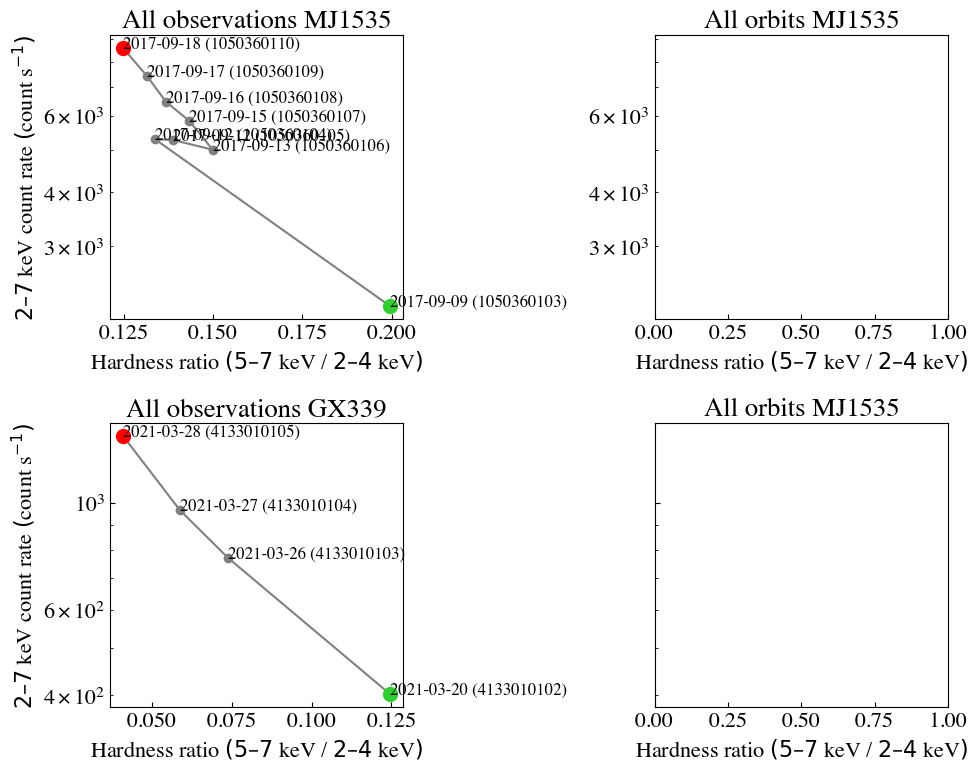

In [20]:
standard_plot(w=10,h=8)
ax1 = plt.subplot(2,2,1)
x,y = [],[]
for i in id_v_MJ: 
    x.append(counts_5to7_MJ[i]/counts_2to4_MJ[i])
    y.append(counts_2to7_MJ[i])
    ax1.annotate(obs_v_MJ[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7_MJ[i]/counts_2to4_MJ[i],counts_2to7_MJ[i]),fontsize=12)

plt.semilogy(x,y,'.-',color='gray',markersize=12)
plt.semilogy(x[0],y[0],'.',color='limegreen',markersize=20)
plt.semilogy(x[-1],y[-1],'.',color='red',markersize=20)
ax1.set_xlabel('Hardness ratio $(5–7$ keV / $2–4$ keV$)$')
ax1.set_ylabel('$2–7$ keV count rate $($count s$^{-1})$')
ax1.tick_params(axis='both',which='both',direction='in')
ax1.set_title('All observations MJ1535')
save_x, save_y = copy.deepcopy(x),copy.deepcopy(y)

ax2 = plt.subplot(2,2,2, sharey = ax1)
x,y = [],[]
import matplotlib.cm as cm
cmap = cm.get_cmap(name='rainbow')
for count,i in enumerate(id_v_MJ): 
    try:
        color = cmap(count*40)
        for part in range(1,15):
            key = i+'part{}'.format(part)
            x_temp = counts_5to7_MJ[key]/counts_2to4_MJ[key]
            y_temp = counts_2to7_MJ[key]
            x.append(x_temp)
            y.append(y_temp)
            plt.semilogy(x_temp,y_temp,'.',color='gray',markersize=12)
            #ax.annotate(obs_v[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7[i]/counts_2to4[i],counts_2to7[i]),fontsize=12)
    except KeyError:
        pass
ax2.tick_params(axis='both',which='both',direction='in')
if len(x) > 1:
    save_x.insert(0,x[0]), save_y.insert(0,y[0])
    save_x.append(x[-1]), save_y.append(y[-1])
    plt.semilogy(save_x, save_y,'-',color='lightgray',markersize=12)

ax2.set_xlabel('Hardness ratio $(5–7$ keV / $2–4$ keV$)$')
ax2.set_title('All orbits MJ1535')

ax3 = plt.subplot(2,2,3)
x,y = [],[]
for i in id_v_GX: 
    x.append(counts_5to7_GX[i]/counts_2to4_GX[i])
    y.append(counts_2to7_GX[i])
    ax3.annotate(obs_v_GX[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7_GX[i]/counts_2to4_GX[i],counts_2to7_GX[i]),fontsize=12)

plt.semilogy(x,y,'.-',color='gray',markersize=12)
plt.semilogy(x[0],y[0],'.',color='limegreen',markersize=20)
plt.semilogy(x[-1],y[-1],'.',color='red',markersize=20)
ax3.set_xlabel('Hardness ratio $(5–7$ keV / $2–4$ keV$)$')
ax3.set_ylabel('$2–7$ keV count rate $($count s$^{-1})$')
ax3.tick_params(axis='both',which='both',direction='in')
ax3.set_title('All observations GX339')
save_x, save_y = copy.deepcopy(x),copy.deepcopy(y)

ax2 = plt.subplot(2,2,4, sharey = ax3)
x,y = [],[]
cmap = cm.get_cmap(name='rainbow')
for count,i in enumerate(id_v_GX): 
    try:
        color = cmap(count*40)
        for part in range(1,15):
            key = i+'part{}'.format(part)
            x_temp = counts_5to7_GX[key]/counts_2to4_GX[key]
            y_temp = counts_2to7_GX[key]
            x.append(x_temp)
            y.append(y_temp)
            plt.semilogy(x_temp,y_temp,'.',color='gray',markersize=12)
            #ax.annotate(obs_v[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7[i]/counts_2to4[i],counts_2to7[i]),fontsize=12)
    except KeyError:
        pass
ax2.tick_params(axis='both',which='both',direction='in')
ax2.label_outer()

if len(x) > 1:
    save_x.insert(0,x[0]), save_y.insert(0,y[0])
    save_x.append(x[-1]), save_y.append(y[-1])
    plt.semilogy(save_x, save_y,'-',color='lightgray',markersize=12)

ax2.set_xlabel('Hardness ratio $(5–7$ keV / $2–4$ keV$)$')
ax2.set_title('All orbits MJ1535')

plt.tight_layout()
plt.show()

# Observation by observation MAXIJ1535

## obs_id = 1050360103

In [36]:
obs_id = '1050360103'
path = "Data/MAXIJ1535_571/using_nicerl2/"
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 14.7, rms = 0.236, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 203.4, rms = 0.152, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 598.9, rms = 0.192, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 500.8, rms = 0.197, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 397.6, rms = 0.216, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 346.1, rms = 0.225, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 276.4, rms = 0.232, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 209.0, rms = 0.261, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 153.9, rms = 0.243, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 113.5, rms = 0.238, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 83.1, rms = 0.228, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 61.2, rms = 0.258, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 45.7, rms = 0.229, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 30.7, rms = nan, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 21.2, rms = 0.264, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 25.1, rms = 0.100, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 11.4, rms = 0.365, dt = 0.005


lc_v[0].N/m =  12.231201171875 


Length of part:  3.7596435546875

Length of part:  4.2479248046875

Length of part:  4.223388671875


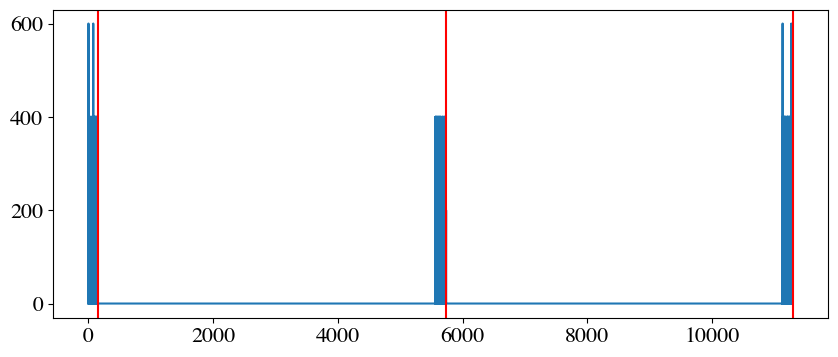

In [37]:
stops = [8000]
stops = [4000,8000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [38]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [39]:
lc_verysoft = [merge_energies_lc(lc_v[0:3])]
lc_soft = [merge_energies_lc(lc_v[3:6])]
lc_hard = [merge_energies_lc(lc_v[6:17])]

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [8]:
ps_verysoft_parts = [PowerSpectrum(lc_verysoft,m=2**12,timer_on=False,percent_limit=95)]
ps_soft_parts = [PowerSpectrum(lc_soft,m=2**12,timer_on=False,percent_limit=95)]
ps_hard_parts = [PowerSpectrum(lc_hard,m=2**12,timer_on=False,percent_limit=95)]

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 24 segments were disregarded due to lower percent limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 7, percent of filled time bins = 0.38
Seg nr = 16, percent of filled time bins = 0.38
Power spectra done! 

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 24 segments were disregarded due to lower percent limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 7, percent of filled time bins = 0.38
Seg nr = 16, percent of filled time bins = 0.38
Power spectra done! 

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 24 segments were disregarded due to lower percent limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 7, percent of filled t

In [16]:
save_path_TL = save_timelag(obs_id,lc_verysoft,lc_soft,lc_hard,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,m_v=[2**9,2**10,2**12])



Save at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy


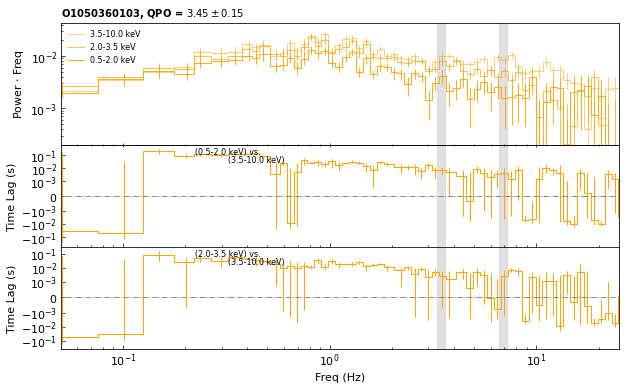

In [17]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [0]: 
        
    if i == 0:
        mi, ma = 3.3,3.6
        color='orange'
    elif i == 1:
        mi, ma = 2.2,2.7
        color='purple'

    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O1050360103')
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100,w=10)


## obs_id = 1050360104

In [40]:
obs_id = '1050360104'
path = "Data/MAXIJ1535_571/using_nicerl2/"
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 39.5, rms = 0.168, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 560.8, rms = 0.069, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 1746.2, rms = 0.088, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1438.2, rms = 0.113, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1068.7, rms = 0.142, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 862.2, rms = 0.165, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 637.6, rms = 0.180, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 447.8, rms = 0.194, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 308.3, rms = 0.202, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 212.0, rms = 0.205, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 147.7, rms = 0.206, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 103.5, rms = 0.211, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 72.9, rms = 0.210, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 47.2, rms = 0.183, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 31.6, rms = 0.199, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 35.9, rms = 0.239, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 15.3, rms = 0.171, dt = 0.005

lc_v[0].N/m =  129.562255859375 


Length of part:  8.300537109375

Length of part:  24.388916015625

Length of part:  20.1885986328125

Length of part:  13.5496826171875

Length of part:  20.8983154296875

Length of part:  20.8494873046875

Length of part:  21.386474609375


(0, 67998)

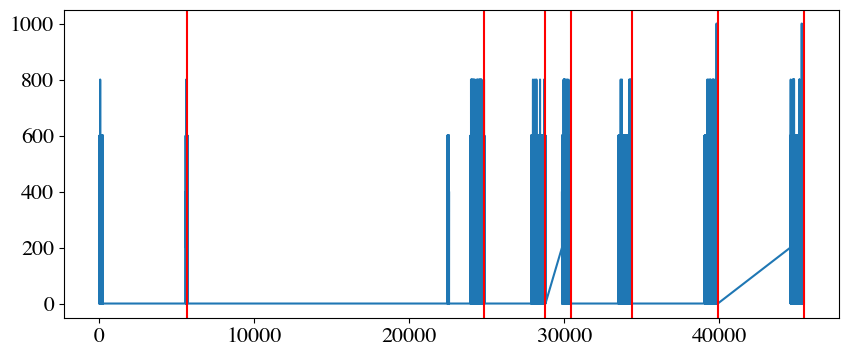

In [41]:
stops = [20000,32000]
stops = [20000,26000,29800,32000,36000,42000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

# Remove first part:
start_v.pop(0),stop_v.pop(0)

### Hardness ratio map

In [42]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [934]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [935]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (67998)-(544176)
New part for time indices: (544176)-(1061372)
New part for time indices: (67998)-(544176)
New part for time indices: (544176)-(1061372)
New part for time indices: (67998)-(544176)
New part for time indices: (544176)-(1061372)


In [936]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
7 of 61 segments were disregarded due to lower percentage limit set to 95.00%:
3 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.24
Seg nr = 3, Percentage of filled time bins = 2.87
Seg nr = 25, Percentage of filled time bins = 1.34
Seg nr = 29, Percentage of filled time bins = 89.11
Seg nr = 33, Percentage of filled time bins = 93.17
Seg nr = 36, Percentage of filled time bins = 32.51
Seg nr = 47, Percentage of filled time bins = 3.70
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
3 of 64 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 1.31
Seg nr = 21, Percentage of filled time bins = 0.86
Seg nr = 42, Percentage

In [961]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

Save at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV


Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy


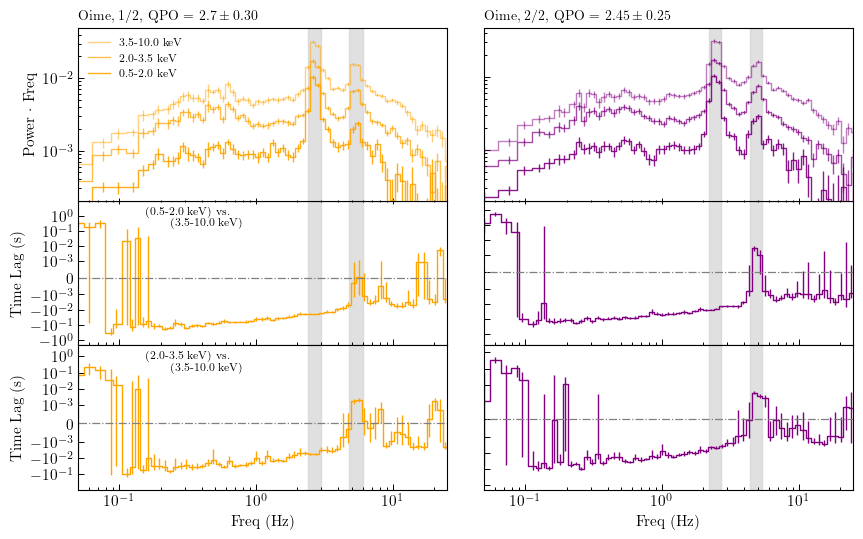

In [28]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [0,1]: 
        
    if i == 0:
        mi, ma = 2.4,3
        color='orange'
    elif i == 1:
        mi, ma = 2.2,2.7
        color='purple'

    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100)

### Time Lag vs Energy

Saved at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag_vs_Energy/1050360104_part1_refband4.0_4.5keV.npy


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


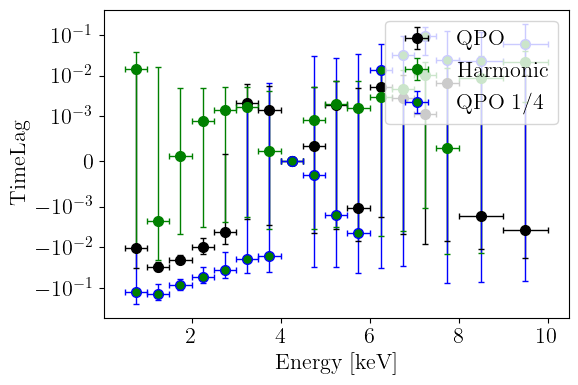

In [153]:
part = 1
ref = 7
if part == 0:
    mi, ma = 2.4,3
elif part == 1:
    mi, ma = 2.2,2.7

lc_parts, save_path_TL = timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref)

In [ ]:
# Questions:
# 1) What ref band to choose?
# 2) soft band leading = positive 

## obs_id = 1050360105

In [43]:
obs_id = '1050360105'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 39.4, rms = 0.120, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 562.8, rms = 0.069, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 1735.1, rms = 0.093, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1421.2, rms = 0.120, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1055.4, rms = 0.146, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 854.8, rms = 0.169, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 635.5, rms = 0.186, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 450.7, rms = 0.195, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 312.3, rms = 0.210, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 216.5, rms = 0.208, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 151.5, rms = 0.207, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 106.8, rms = 0.214, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 75.6, rms = 0.199, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 49.2, rms = 0.216, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 33.0, rms = 0.217, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 37.7, rms = 0.220, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 16.2, rms = 0.208, dt = 0.005

lc_v[0].N/m =  187.0877685546875 


Length of part:  77.2369384765625

Length of part:  43.3519287109375

Length of part:  66.4986572265625


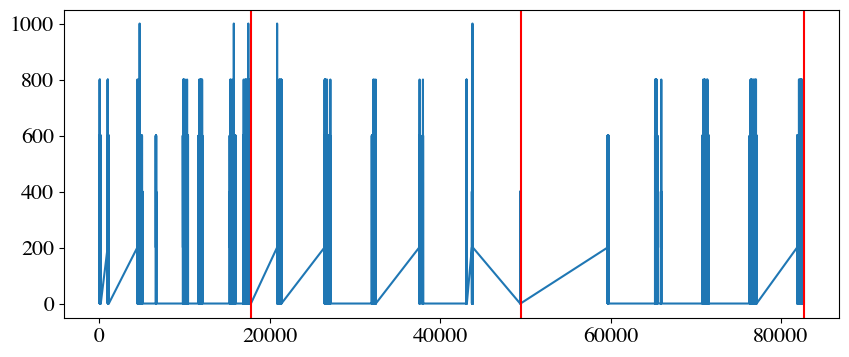

In [44]:
stops = [20000,50000]
#stops = [7000,14000,20000,23000,27000,30000,36000,40000,50000,68000,72000,80000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [45]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [264]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [265]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(632725)
New part for time indices: (632725)-(987864)
New part for time indices: (987864)-(1532621)
New part for time indices: (0)-(632725)
New part for time indices: (632725)-(987864)
New part for time indices: (987864)-(1532621)
New part for time indices: (0)-(632725)
New part for time indices: (632725)-(987864)
New part for time indices: (987864)-(1532621)


In [266]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
28 of 84 segments were disregarded due to lower percentage limit set to 95.00%:
7 additional segments were used thanks to use_max_data == True
Seg nr = 3, Percentage of filled time bins = 4.77
Seg nr = 7, Percentage of filled time bins = 1.21
Seg nr = 14, Percentage of filled time bins = 43.59
Seg nr = 15, Percentage of filled time bins = 50.58
Seg nr = 16, Percentage of filled time bins = 57.71
Seg nr = 17, Percentage of filled time bins = 41.80
Seg nr = 18, Percentage of filled time bins = 2.55
Seg nr = 20, Percentage of filled time bins = 1.29
Seg nr = 21, Percentage of filled time bins = 80.37
Seg nr = 22, Percentage of filled time bins = 93.17
Seg nr = 23, Percentage of filled time bins = 78.81
Seg nr = 24, Percentage of filled time bins = 61.16
Seg nr = 25, Percentage of filled time bins = 77.32
Seg nr = 26, Percentage of filled time bins = 74.51
Seg nr = 27, Percentage of fi

11 of 47 segments were disregarded due to lower percentage limit set to 95.00%:
4 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 1.32
Seg nr = 11, Percentage of filled time bins = 54.63
Seg nr = 12, Percentage of filled time bins = 0.80
Seg nr = 23, Percentage of filled time bins = 28.84
Seg nr = 24, Percentage of filled time bins = 43.12
Seg nr = 26, Percentage of filled time bins = 80.35
Seg nr = 27, Percentage of filled time bins = 0.84
Seg nr = 39, Percentage of filled time bins = 0.80
Seg nr = 41, Percentage of filled time bins = 11.44
Seg nr = 43, Percentage of filled time bins = 0.80
Seg nr = 46, Percentage of filled time bins = 6.07
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
8 of 68 segments were disregarded due to lower percentage limit set to 95.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage

In [267]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
42 of 2144 segments were disregarded due to lower percentage limit set to 90.00%:
17 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.01
Seg nr = 87, Percentage of filled time bins = 0.02
Seg nr = 293, Percentage of filled time bins = 38.96
Seg nr = 296, Percentage of filled time bins = 38.96
Seg nr = 298, Percentage of filled time bins = 38.96
Seg nr = 299, Percentag

6 of 35 segments were disregarded due to lower percentage limit set to 90.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.80
Seg nr = 2, Percentage of filled time bins = 1.48
Seg nr = 6, Percentage of filled time bins = 1.53
Seg nr = 11, Percentage of filled time bins = 55.34
Seg nr = 15, Percentage of filled time bins = 1.68
Seg nr = 25, Percentage of filled time bins = 1.70
Power spectra done! 

Cross spectrum computed.
Computing the noiseless coherence...
Cross spectra already found.
Noiseless coherence found (in 0.01 sec).
Only use freq < 0.488 to avoid to much overlaping.
Time lag for m = 16384 computed. 

---------------------------------------------------------------------------------------------------
                           Time lag found (in 22.88 sec).
---------------------------------------------------------------------------------------------------


Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy


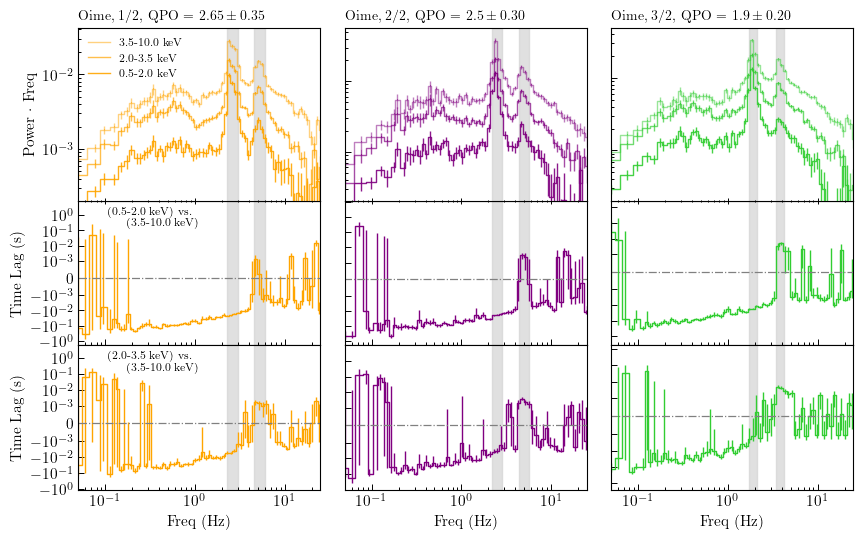

In [36]:
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0,1,2]: 
        
    if i == 0:
        mi, ma = 2.3,3
        color='orange'
    elif i == 1:
        mi, ma = 2.2,2.8
        color='purple'
    elif i == 2:
        mi, ma = 1.7,2.1
        color='limegreen'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100)

### Time Lag vs Energy

Saved at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag_vs_Energy/1050360105_part2_refband4.0_4.5keV.npy


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


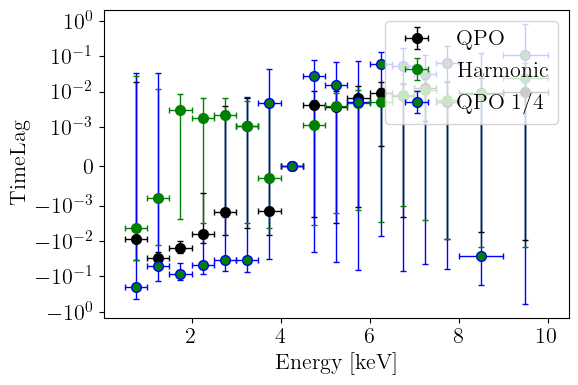

In [161]:
part = 2
ref = 7
if part == 0:
    mi, ma = 2.3,3
elif part == 1:
    mi, ma = 2.2,2.8
elif part == 2:
    mi, ma = 1.7,2.1

lc_parts, save_path_TL = timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref)

## obs_id = 1050360106

In [55]:
obs_id = '1050360106'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 37.3, rms = 0.142, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 538.5, rms = 0.083, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 1631.1, rms = 0.104, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1323.4, rms = 0.129, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 981.9, rms = 0.159, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 802.6, rms = 0.181, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 605.4, rms = 0.195, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 435.8, rms = 0.207, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 307.3, rms = 0.208, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 216.4, rms = 0.212, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 153.1, rms = 0.211, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 109.1, rms = 0.216, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 78.0, rms = 0.213, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 51.2, rms = 0.234, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 34.7, rms = 0.184, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 39.9, rms = 0.223, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 17.3, rms = 0.207, dt = 0.005


lc_v[0].N/m =  143.55078125 


Length of part:  61.0592041015625

Length of part:  53.00146484375

Length of part:  29.4898681640625


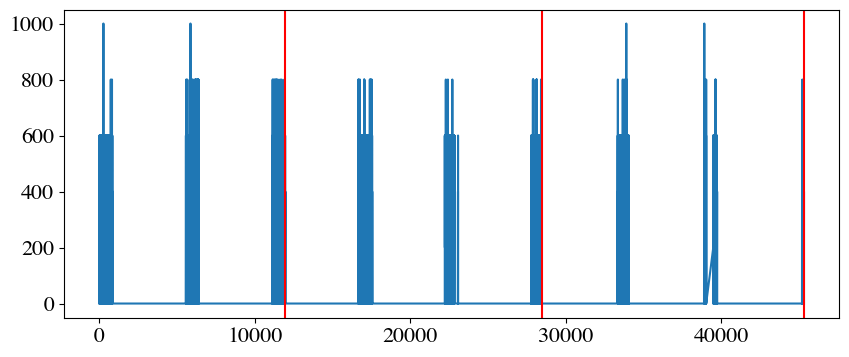

In [47]:
stops = [15000,30000]
#stops = [5000,10000,15000,20000,25000,30000,36000,40000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [48]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)

New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)
New part for time indices: (0)-(500197)


New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New part for time indices: (500197)-(934385)
New

### Time Lag

In [457]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [274]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(500197)
New part for time indices: (500197)-(934385)
New part for time indices: (934385)-(1175966)
New part for time indices: (0)-(500197)
New part for time indices: (500197)-(934385)
New part for time indices: (934385)-(1175966)
New part for time indices: (0)-(500197)
New part for time indices: (500197)-(934385)
New part for time indices: (934385)-(1175966)


In [275]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 62 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 20, Percentage of filled time bins = 0.86
Seg nr = 41, Percentage of filled time bins = 0.86
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
4 of 55 segments were disregarded due to lower percentage limit set to 95.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.86
Seg nr = 22, Percentage of filled time bins = 0.87
Seg nr = 38, Percentage of filled time bins = 0.82
Seg nr = 54, Percentage of filled time bins = 87.20
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
5 of 31 segments were disregarded due to lower p

In [276]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
17 of 950 segments were disregarded due to lower percentage limit set to 90.00%:
7 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.03
Seg nr = 554, Percentage of filled time bins = 38.96
Seg nr = 557, Percentage of filled time bins = 38.96
Seg nr = 559, Percentage of filled time bins = 38.96
Seg nr = 560, Percentage of filled time bins = 38.96
Seg nr = 561, Percentag

Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy


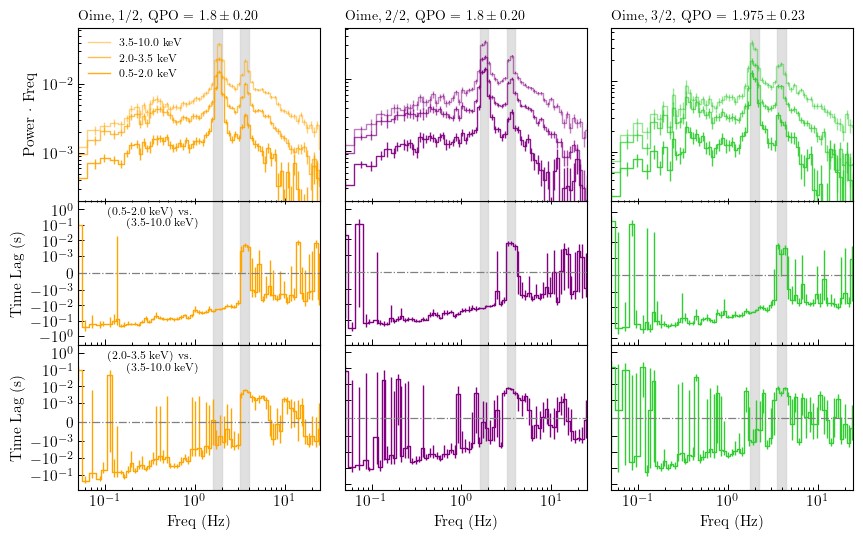

In [78]:
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0,1,2]: 
        
    if i == 0:
        mi, ma = 1.6,2
        color='orange'
    elif i == 1:
        mi, ma = 1.6,2
        color='purple'
    elif i == 2:
        mi, ma = 1.75,2.2
        color='limegreen'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100)

### Time Lag vs Energy

Saved at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag_vs_Energy/1050360106_part2_refband4.0_4.5keV.npy


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


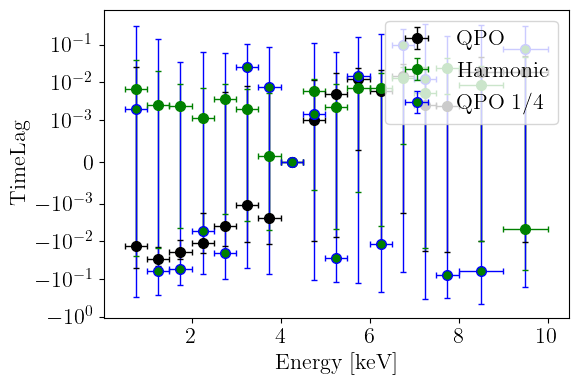

In [133]:
part = 2
ref = 7
if part == 0:
    mi, ma = 1.6,2
elif part == 1:
    mi, ma = 1.6,2
elif part == 2:
    mi, ma = 1.75,2.2

lc_parts, save_path_TL = timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref)

**To test:**

Do you want to plot the time lag [y/n]? y


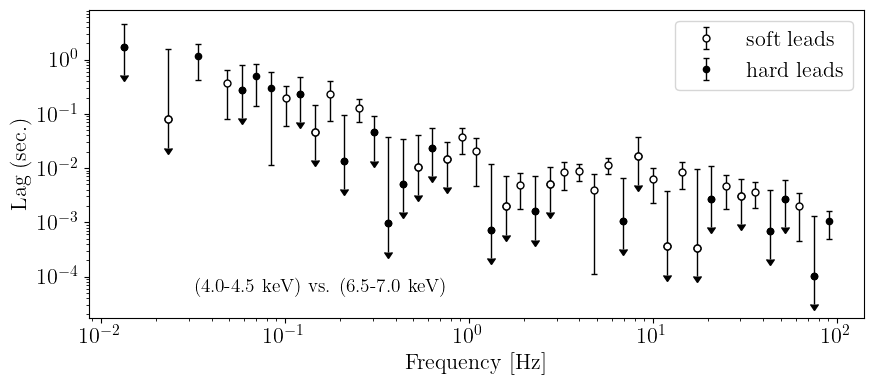

In [99]:
i = 12
part = 0 
ref = 7

x,t,d = time_lag([lc_parts[i][part],lc_parts[ref][part]], [2**8,2**12,2**14])

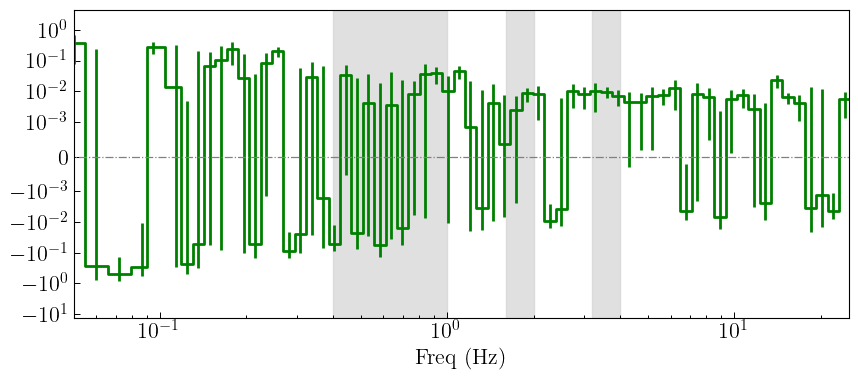

In [100]:
standard_plot()
ax = plt.gca()
x0,t0,d0 = x,t,d
x,t,d = log_rebin(x0,t0,d0,num=100)
ax.step(x,-t,'g',where='mid',linewidth=2)
ax.errorbar(x,-t,yerr=d,fmt='.',color='g',markersize=0,capsize=0,linewidth=2)
ax.tick_params(which='both',direction='in')
ax.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
ax.set_xlabel('Freq (Hz)')
ax.set_yscale('symlog', linthresh=0.001)
ax.set_xlim([0.05,25])
mi, ma = 1.6,2
ax.axvspan(mi/4,ma/2,color='lightgray',alpha=0.7)
ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
ax.label_outer()
ax.set_xscale('log')
ax.tick_params(which='minor',length=2,width=0.7)
ax.tick_params(which='major',length=4,width=0.7)

### Different energy bands

In [509]:
part=1
obj = 'MAXIJ1535_571'

Emin_v = [0.5,0.5,0.5,0.5,0.5,1,1,2,2]
Edivide_v = [1.5,2,2.5,3.5,5,3,5,3.5,5.5]

for Emin,Edivide in zip(Emin_v,Edivide_v):
    # Convert between energy and index for lightcurve starting at that energy 
    Edict = {}
    for i in range(0,len(lc_v)):
        Edict[0.5+0.5*i] = i

    # Pick out soft/hard
    lc_soft = merge_energies_lc(lc_v[Edict[Emin]:Edict[Edivide]])
    lc_hard = merge_energies_lc(lc_v[Edict[Edivide]:])

    # Check if already have done
    save_path_TL = "../../Data/{}/using_nicerl2/TimeLag/different_energy_bands/{}_{}-{}vs{}-{}keV_part{}.npy".format(obj,obs_id,lc_soft.Emin,lc_soft.Emax,lc_hard.Emin,lc_hard.Emax,part)
    try:
        np.load(save_path_TL,allow_pickle=True)
        already_done = True
    except FileNotFoundError:
        already_done = False
        pass
    
    if not already_done:
        # Pick out part
        lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
        lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

        # Just use one part
        lc_soft = lc_soft_parts[part]
        lc_hard = lc_hard_parts[part]

        # Find power spectra
        ps_soft = PowerSpectrum(lc_soft,m=2**13)
        ps_hard = PowerSpectrum(lc_hard,m=2**13)
        x = ps_soft.xf
        ps_s_save = [ps_soft.fft_rate, ps_soft.fft_rate_err, ps_soft.Emin, ps_soft.Emax] #soft 
        ps_h_save = [ps_hard.fft_rate, ps_hard.fft_rate_err, ps_hard.Emin, ps_hard.Emax] #hard

        # Find timelag
        x0,t0,d0 = time_lag([lc_soft,lc_hard], [2**8,2**12,2**14], auto=True)
        tl = [x0,t0,d0]

        # Save
        np.save(save_path_TL,[x,ps_s_save,ps_h_save,tl])


Calculating the power spectra...
Current progress: 100.0%
Current run time:  0.08  minutes
Expected run time:  0.08  minutes
Percentage of filled time bins (segment 54): 87.20
4 of 55 segments were disregarded due to lower percentage limit set to 90.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.86
Seg nr = 22, Percentage of filled time bins = 0.87
Seg nr = 38, Percentage of filled time bins = 0.82
Seg nr = 54, Percentage of filled time bins = 87.20
Power spectra done! 

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross s

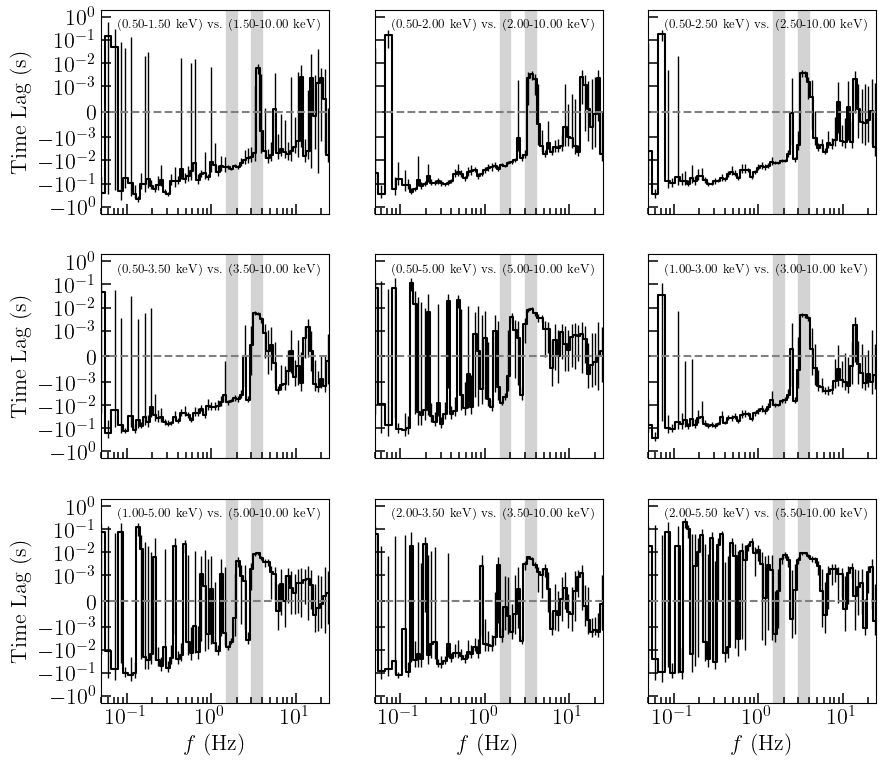

In [529]:
files = glob.glob('../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/different_energy_bands/1050360106_*.npy')
files.sort()

mi,ma = 1.5,2

standard_plot(h=9,w=10)
nr_f = len(files)
for i,f in enumerate(files):
    plt.subplot(3,3,i+1)
    
    [x,ps_s_save,ps_h_save,tl] = np.load(f,allow_pickle=True)
    
    Emin_s,Emax_s = ps_s_save[2],ps_s_save[3]
    Emin_h,Emax_h = ps_h_save[2],ps_h_save[3]

    x0,t0,d0 = tl

    x,t,d = log_rebin(x0,t0,d0,num=100)
    ax = plt.gca()
    plt.step(x,-t,'k',where='mid')
    plt.plot([-10000,10000],[0,0],'--',color='gray',linewidth=1.5)
    ax.errorbar(x,-t,yerr=d,fmt='.',color='k',markersize=0,capsize=0, elinewidth=1, markeredgewidth=1)
    ax.axvspan(mi,ma,color='lightgray')
    ax.axvspan(mi*2,ma*2,color='lightgray')
    
    ax.set_xscale('log')
    ax.set_xlim(0.05,25)
    #ax.set_xlim(0.1,12)
    #ax.set_xlim(0.05,110)
    ax.set_ylim(-2,2)
    plt.yscale('symlog', linthresh=0.001)
    ax.tick_params(which='both',direction='in')
    ax.tick_params(which='minor',length=4,width=1.1)
    ax.tick_params(which='major',length=7,width=1.1)
    plt.xlabel('$f$ (Hz)')
    plt.ylabel('Time Lag (s)')

    Eband1, Eband2 = '{:.2f}-{:.2f}'.format(Emin_s,Emax_s),'{:.2f}-{:.2f}'.format(Emin_h,Emax_h)
    ax.text(0.52,0.93,'({} keV) vs. ({} keV)'.format(Eband1,Eband2),fontsize=9,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.label_outer()
    
plt.show()

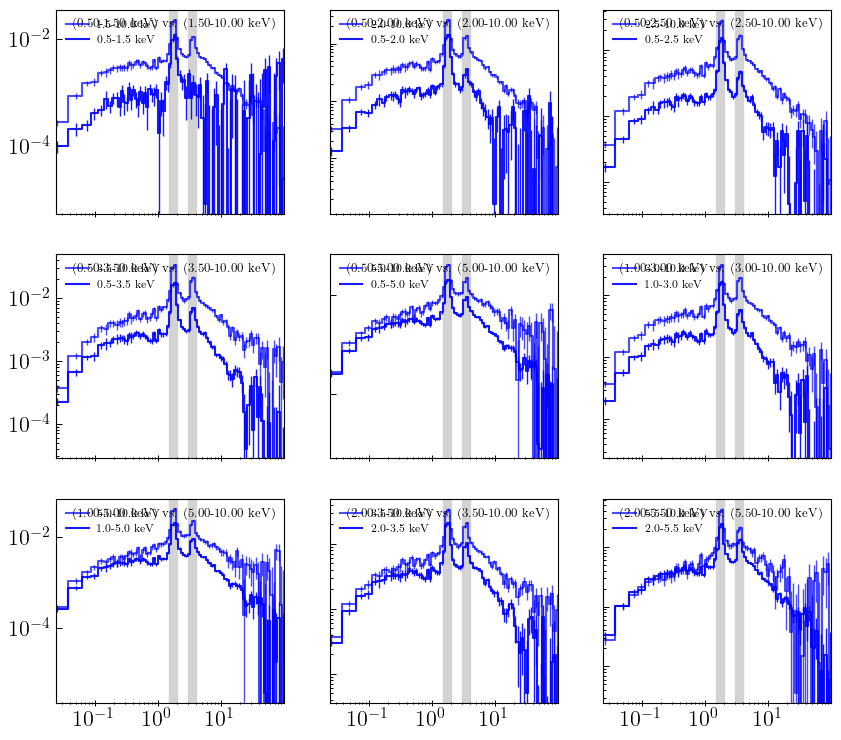

In [528]:
files = glob.glob('../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/different_energy_bands/1050360106_*.npy')
files.sort()

mi,ma = 1.5,2

standard_plot(h=9,w=10)
nr_f = len(files)
for i,f in enumerate(files):
    plt.subplot(3,3,i+1)
    
    [x,ps_s_save,ps_h_save,tl] = np.load(f,allow_pickle=True)
    
    Emin_s,Emax_s = ps_s_save[2],ps_s_save[3]
    Emin_h,Emax_h = ps_h_save[2],ps_h_save[3]

    ax = plt.gca()
    
    for ps,alp in zip([ps_h_save,ps_s_save],[0.7,0.9]):

        p,p_err,Emin,Emax = ps[0],ps[1],ps[2],ps[3]

        molb, fPf, fPferr = log_rebin(x, p*x, p_err*x, num=100) 
        label = '{}-{} keV'.format(Emin,Emax)
        ax.step(molb, fPf, where='mid',color='b',label=label,alpha=alp)
        ax.errorbar(molb, fPf, fPferr, fmt=',',color='b',elinewidth=1,alpha=alp)
            
    plt.legend(frameon=False,loc='upper left',fontsize=8)
    ax.axvspan(mi,ma,color='lightgray')
    ax.axvspan(mi*2,ma*2,color='lightgray')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x[0],x[-1]) # fix x-limits of axis so that the following don't mess it up
    #ax0.set_ylim(0.0004,0.006) # fix x-limits of axis so that the following don't mess it up
    ax.tick_params(axis='x',which='both',direction='inout')
    ax.tick_params(axis='y',which='both',direction='in')
    ax.tick_params(which='minor',length=2,width=0.7)
    ax.tick_params(which='major',length=4,width=0.7)
    ax.zorder = 1 #to make ticks visible 

    Eband1, Eband2 = '{:.2f}-{:.2f}'.format(Emin_s,Emax_s),'{:.2f}-{:.2f}'.format(Emin_h,Emax_h)
    ax.text(0.52,0.93,'({} keV) vs. ({} keV)'.format(Eband1,Eband2),fontsize=9,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.label_outer()
    
plt.show()

## obs_id = 1050360107

In [49]:
obs_id = '1050360107'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 43.2, rms = 0.078, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 614.2, rms = 0.066, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 1895.0, rms = 0.098, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1555.5, rms = 0.121, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1157.7, rms = 0.148, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 942.2, rms = 0.169, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 705.3, rms = 0.185, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 503.3, rms = 0.196, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 350.6, rms = 0.206, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 244.0, rms = 0.217, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 172.4, rms = 0.215, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 122.2, rms = 0.208, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 86.8, rms = 0.189, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 56.6, rms = 0.190, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 38.4, rms = 0.240, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 43.6, rms = 0.199, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 18.8, rms = 0.222, dt = 0.005

lc_v[0].N/m =  43.6033935546875 


Length of part:  21.8016357421875

Length of part:  21.801513671875


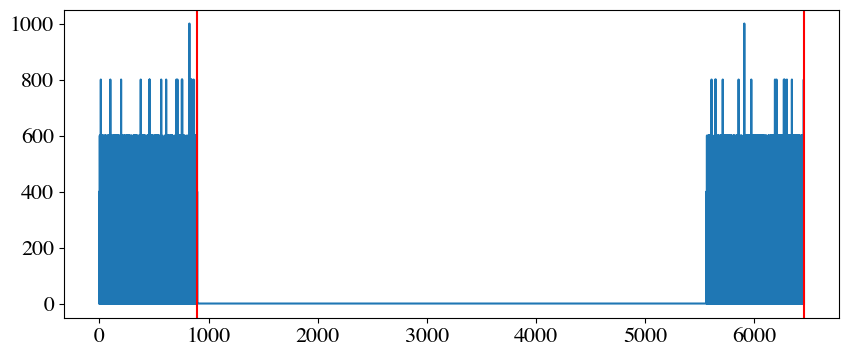

In [50]:
stops = [3000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [51]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [281]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [282]:
lc_verysoft_parts = [lc_verysoft]
lc_soft_parts = [lc_soft]
lc_hard_parts = [lc_hard]

In [283]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 43 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 21, Percentage of filled time bins = 0.87
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 43 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 21, Percentage of filled time bins = 0.87
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 43 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 21, Percentage of filled time bins = 0.87
Power spectra done! 



In [284]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360107_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy


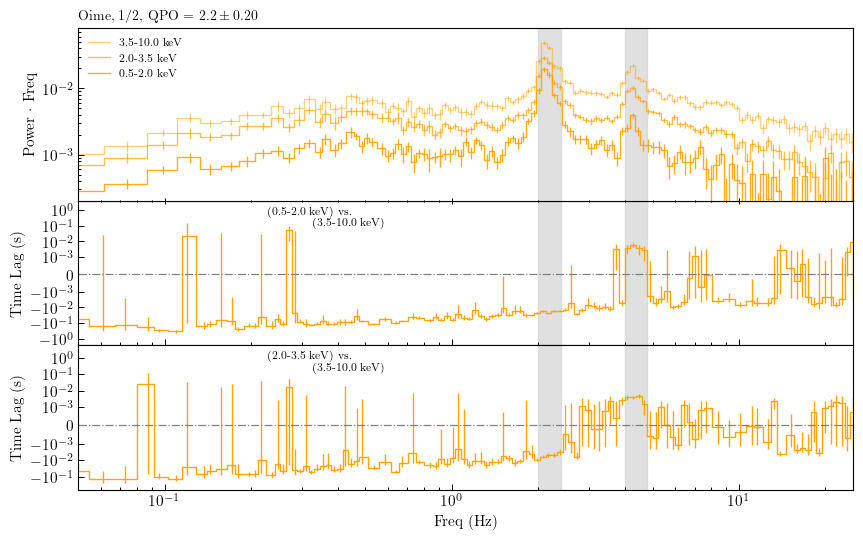

In [58]:
save_path_TL = '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360107_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0]: 
        
    if i == 0:
        mi, ma = 2,2.4
        color='orange'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=200)

### Time Lag vs Energy

Saved at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag_vs_Energy/1050360107_part0_refband4.0_4.5keV.npy


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


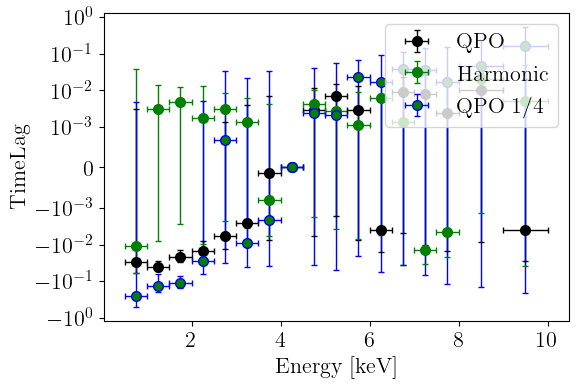

In [139]:
part = 0
ref = 7
if part == 0:
    mi, ma = 2,2.4

lc_parts, save_path_TL = timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref)

## obs_id = 1050360108

In [52]:
obs_id = '1050360108'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 47.5, rms = 0.165, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 661.9, rms = 0.065, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 2079.8, rms = 0.087, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1733.2, rms = 0.113, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1294.9, rms = 0.140, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 1053.1, rms = 0.159, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 783.0, rms = 0.176, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 551.8, rms = 0.186, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 380.8, rms = 0.198, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 263.4, rms = 0.196, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 183.4, rms = 0.210, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 128.2, rms = 0.211, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 90.8, rms = 0.206, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 59.1, rms = 0.192, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 39.7, rms = 0.168, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 45.1, rms = 0.226, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 19.2, rms = 0.217, dt = 0.00

lc_v[0].N/m =  61.7880859375 


Length of part:  16.7479248046875

Length of part:  13.50048828125

Length of part:  14.916015625

Length of part:  7.787109375

Length of part:  4.3450927734375

Length of part:  2.9779052734375

Length of part:  1.5133056640625


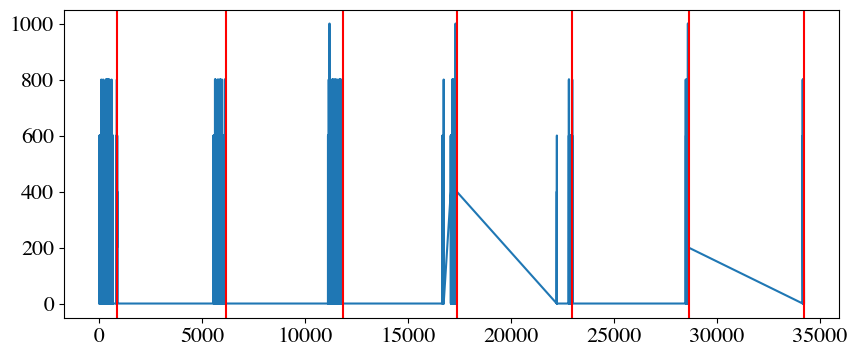

In [53]:
stops = [15000]
stops = [5000,10000,15000,20000,25000,30000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [54]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [290]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [291]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(369987)
New part for time indices: (369987)-(506166)
New part for time indices: (0)-(369987)
New part for time indices: (369987)-(506166)
New part for time indices: (0)-(369987)
New part for time indices: (369987)-(506166)


In [292]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
8 of 48 segments were disregarded due to lower percentage limit set to 95.00%:
3 additional segments were used thanks to use_max_data == True
Seg nr = 15, Percentage of filled time bins = 18.97
Seg nr = 16, Percentage of filled time bins = 0.87
Seg nr = 28, Percentage of filled time bins = 59.39
Seg nr = 29, Percentage of filled time bins = 83.65
Seg nr = 31, Percentage of filled time bins = 0.82
Seg nr = 39, Percentage of filled time bins = 91.09
Seg nr = 42, Percentage of filled time bins = 80.37
Seg nr = 45, Percentage of filled time bins = 46.04
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
7 of 19 segments were disregarded due to lower percentage limit set to 95.00%:
3 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.84
Seg nr = 2, Percen

In [293]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
19 of 537 segments were disregarded due to lower percentage limit set to 90.00%:
6 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.03
Seg nr = 52, Percentage of filled time bins = 0.37
Seg nr = 54, Percentage of filled time bins = 38.96
Seg nr = 58, Percentage of filled time bins = 20.37
Seg nr = 98, Percentage of filled time bins = 38.96
Seg nr = 113, Percentage of 

Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360108_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360108_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy


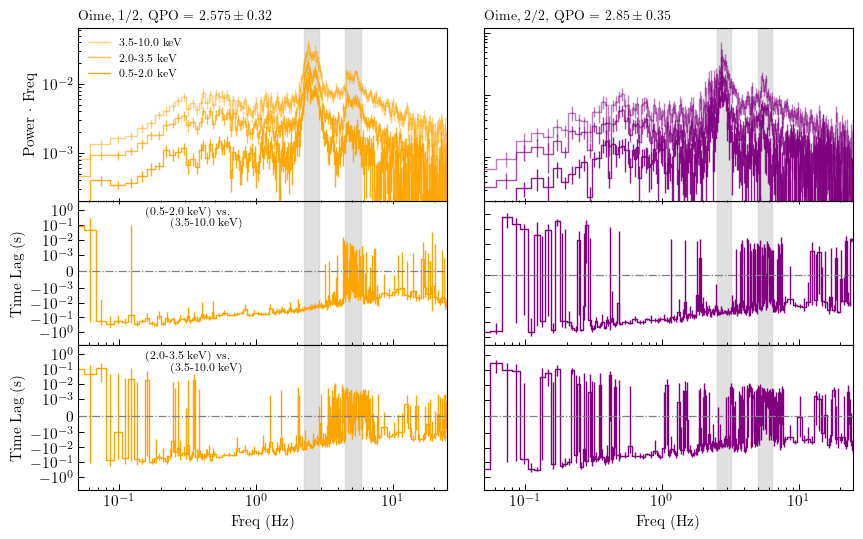

In [97]:
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360108_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0,1]: 
        
    if i == 0:
        mi, ma = 2.25,2.9
        color='orange'
    elif i == 1:
        mi, ma = 2.5,3.2
        color='purple'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=500)

## obs_id = 1050360109

In [78]:
obs_id = '1050360109'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 54.1, rms = 0.077, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 735.3, rms = 0.062, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 2350.8, rms = 0.078, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 1989.4, rms = 0.100, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1501.1, rms = 0.126, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 1221.8, rms = 0.147, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 904.0, rms = 0.165, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 634.1, rms = 0.183, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 432.0, rms = 0.186, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 295.5, rms = 0.199, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 203.5, rms = 0.192, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 140.8, rms = 0.198, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 98.6, rms = 0.206, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 63.6, rms = 0.202, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 42.6, rms = 0.229, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 47.9, rms = 0.210, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 20.4, rms = 0.200, dt = 0.00

lc_v[0].N/m =  81.193115234375 


Length of part:  12.5731201171875

Length of part:  16.0137939453125

Length of part:  5.2479248046875

Length of part:  0.3172607421875

Length of part:  2.733642578125

Length of part:  2.9534912109375

Length of part:  4.7845458984375

Length of part:  15.255859375

Length of part:  21.313232421875


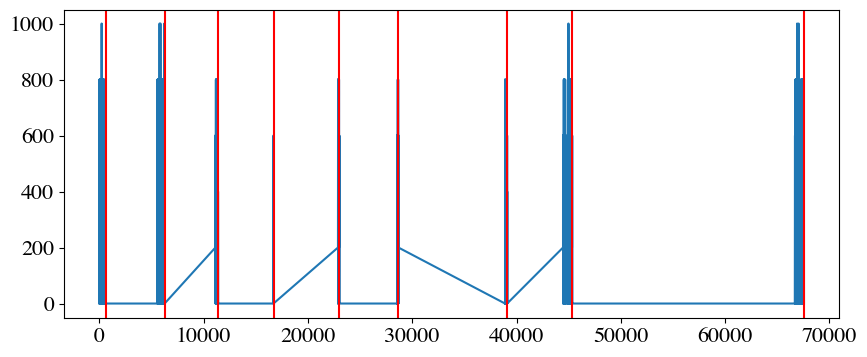

In [79]:
stops = [30000]
stops = [5000,10000,15000,20000,25000,30000,40000,50000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [80]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [577]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [578]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(326363)
New part for time indices: (326363)-(665132)
New part for time indices: (0)-(326363)
New part for time indices: (326363)-(665132)
New part for time indices: (0)-(326363)
New part for time indices: (326363)-(665132)


In [579]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
9 of 40 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 10, Percentage of filled time bins = 71.91
Seg nr = 12, Percentage of filled time bins = 0.81
Seg nr = 25, Percentage of filled time bins = 68.26
Seg nr = 26, Percentage of filled time bins = 70.64
Seg nr = 29, Percentage of filled time bins = 0.83
Seg nr = 31, Percentage of filled time bins = 87.20
Seg nr = 34, Percentage of filled time bins = 66.09
Seg nr = 35, Percentage of filled time bins = 0.35
Seg nr = 38, Percentage of filled time bins = 0.73
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
8 of 43 segments were disregarded due to lower percentage limit set to 95.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percen

In [580]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

Save at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV


Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy


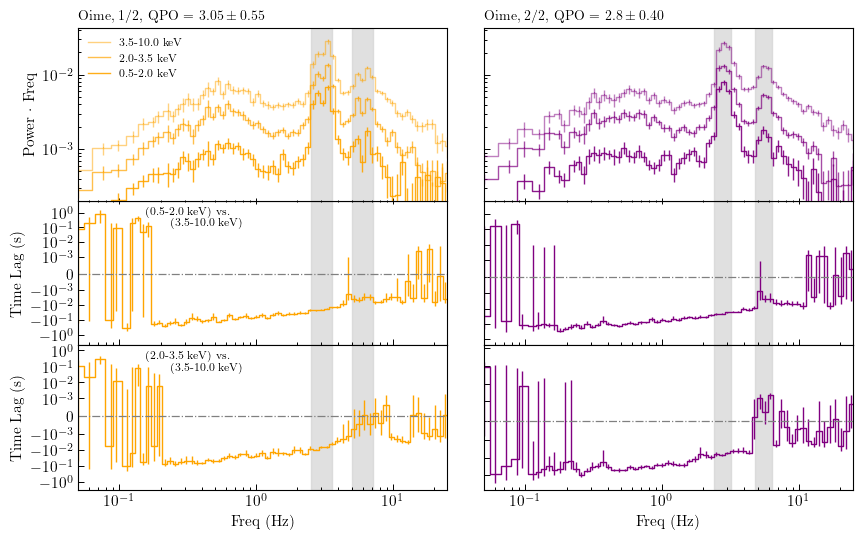

In [77]:
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0,1]: 
        
    if i == 0:
        mi, ma = 2.5,3.6
        color='orange'
    elif i == 1:
        mi, ma = 2.4,3.2
        color='purple'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100)

### Time Lag vs Energy

Saved at:  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag_vs_Energy/1050360109_part1_refband4.0_4.5keV.npy


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


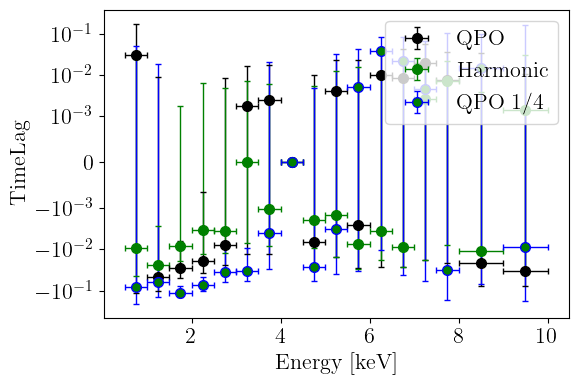

In [143]:
part = 1
ref = 7
if part == 0:
    mi, ma = 2.4,3.2

lc_parts, save_path_TL = timelag_vs_energy(obj,obs_id,lc_v,mi,ma,start_v,stop_v,part,ref)

**To test:**

Do you want to plot the time lag [y/n]? y


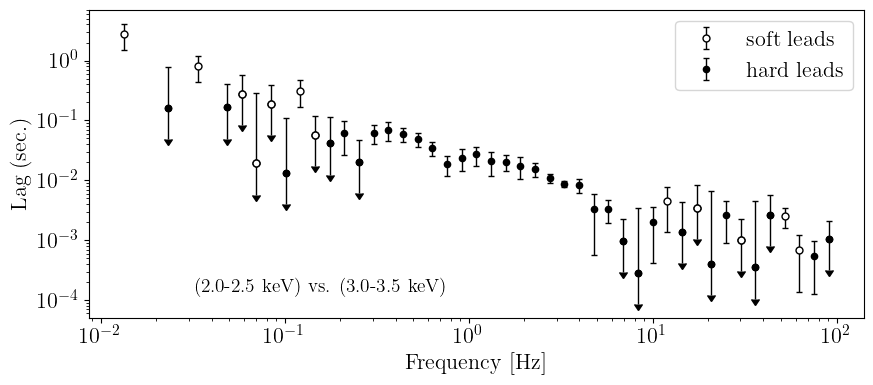

In [148]:
i = 3
part = 0 
ref = 5

x,t,d = time_lag([lc_parts[i][part],lc_parts[ref][part]], [2**8,2**12,2**14])

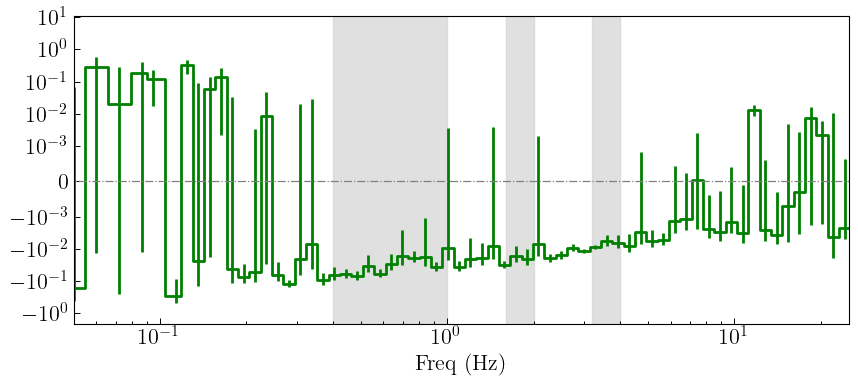

In [149]:
standard_plot()
ax = plt.gca()
x0,t0,d0 = x,t,d
x,t,d = log_rebin(x0,t0,d0,num=100)
ax.step(x,-t,'g',where='mid',linewidth=2)
ax.errorbar(x,-t,yerr=d,fmt='.',color='g',markersize=0,capsize=0,linewidth=2)
ax.tick_params(which='both',direction='in')
ax.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
ax.set_xlabel('Freq (Hz)')
ax.set_yscale('symlog', linthresh=0.001)
ax.set_xlim([0.05,25])
mi, ma = 1.6,2
ax.axvspan(mi/4,ma/2,color='lightgray',alpha=0.7)
ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
ax.label_outer()
ax.set_xscale('log')
ax.tick_params(which='minor',length=2,width=0.7)
ax.tick_params(which='major',length=4,width=0.7)

sad

## obs_id = 1050360110

In [59]:
obs_id = '1050360110'
lc_v = obs_v_MJ[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 61.7, rms = 0.140, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 811.2, rms = 0.051, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 2661.6, rms = 0.067, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 2296.6, rms = 0.089, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 1757.6, rms = 0.110, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 1435.6, rms = 0.132, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 1056.8, rms = 0.151, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 733.9, rms = 0.166, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 493.7, rms = 0.178, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 332.4, rms = 0.182, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 225.6, rms = 0.188, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 153.8, rms = 0.193, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 105.7, rms = 0.210, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 67.8, rms = 0.194, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 45.1, rms = 0.181, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 49.8, rms = 0.206, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 21.0, rms = 0.128, dt = 0.

lc_v[0].N/m =  59.248779296875 


Length of part:  21.483642578125

Length of part:  37.764892578125


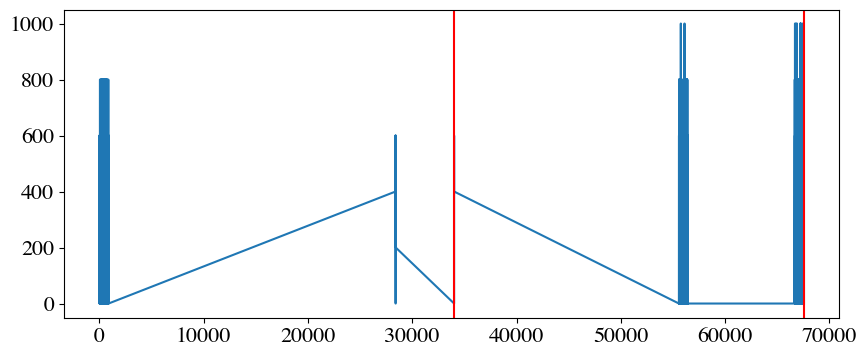

In [60]:
stops = [10000,40000,60000]
stops = [40000]
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)

### Hardness ratio map

In [61]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
clear_output()

### Time Lag

In [305]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [306]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(175994)
New part for time indices: (175994)-(485364)
New part for time indices: (0)-(175994)
New part for time indices: (175994)-(485364)
New part for time indices: (0)-(175994)
New part for time indices: (175994)-(485364)


In [307]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
0 of 21 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True

Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
7 of 40 segments were disregarded due to lower percentage limit set to 95.00%:
3 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.19
Seg nr = 5, Percentage of filled time bins = 83.63
Seg nr = 7, Percentage of filled time bins = 20.08
Seg nr = 8, Percentage of filled time bins = 83.63
Seg nr = 17, Percentage of filled time bins = 77.30
Seg nr = 18, Percentage of filled time bins = 0.40
Seg nr = 23, Percentage of filled time bins = 91.08
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson

In [308]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts)

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
28 of 1221 segments were disregarded due to lower percentage limit set to 90.00%:
13 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.01
Seg nr = 130, Percentage of filled time bins = 38.96
Seg nr = 138, Percentage of filled time bins = 38.96
Seg nr = 149, Percentage of filled time bins = 38.96
Seg nr = 152, Percentage of filled time bins = 38.96
Seg nr = 206, Percent

Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360110_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360110_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy


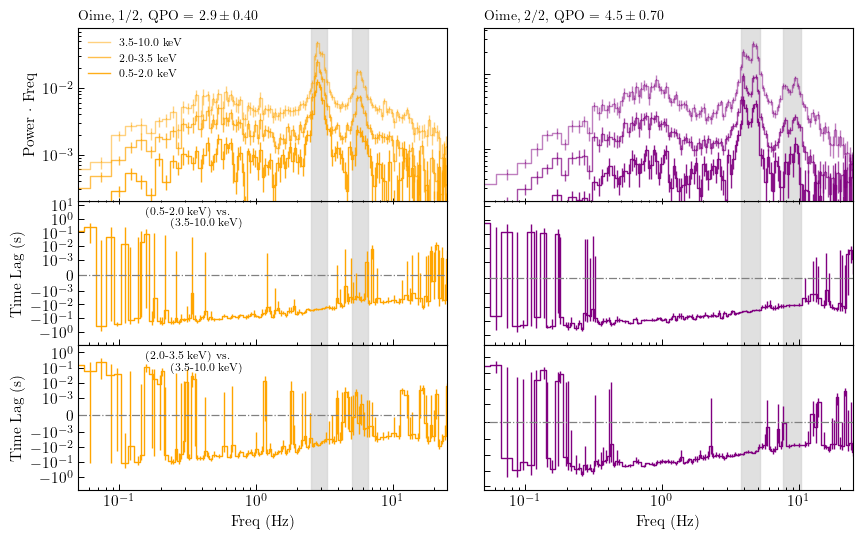

In [189]:
save_path_TL = 'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360110_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

for i in [0,1]: 
        
    if i == 0:
        mi, ma = 2.5,3.3
        color='orange'
    elif i == 1:
        mi, ma = 3.8,5.2
        color='purple'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=200)


# Observation by observation GX339-4

## obs_id = 4133010102

In [62]:
obs_id = '4133010102'
lc_v = obs_v_GX[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 191.8, rms = 0.249, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 401.5, rms = 0.278, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 293.4, rms = 0.296, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 137.1, rms = 0.295, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 78.4, rms = 0.311, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 57.2, rms = 0.286, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 41.0, rms = 0.299, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 29.2, rms = 0.319, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 20.5, rms = 0.277, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 14.7, rms = 0.307, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 10.7, rms = 0.404, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 7.9, rms = 0.388, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 5.7, rms = 0.418, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 3.9, rms = nan, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 2.8, rms = 0.574, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 3.4, rms = 0.563, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 1.6, rms = nan, dt = 0.005


lc_v[0].N/m =  54.1746826171875 


Length of part:  22.1190185546875

Length of part:  32.055419921875


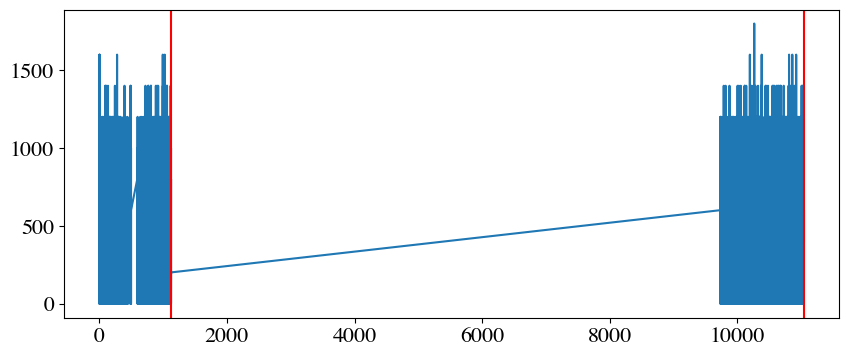

In [63]:
stops = [5000]
#stops = [20000,26000,32000,36000,42000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)


### Hardness ratio map

In [64]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v,obj='GX339')
clear_output()

### Time Lag

In [377]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [378]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(181199)
New part for time indices: (181199)-(443797)
New part for time indices: (0)-(181199)
New part for time indices: (181199)-(443797)
New part for time indices: (0)-(181199)
New part for time indices: (181199)-(443797)


In [379]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
5 of 23 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 8, Percentage of filled time bins = 83.66
Seg nr = 9, Percentage of filled time bins = 87.22
Seg nr = 10, Percentage of filled time bins = 20.80
Seg nr = 11, Percentage of filled time bins = 53.22
Seg nr = 12, Percentage of filled time bins = 83.66
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 32 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.47
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
5 of 23 segments were disregarded due to lower

In [381]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,obj='GX339')


---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
1 of 1025 segments were disregarded due to lower percentage limit set to 90.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.01
Power spectra done! 

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
1 of 1025 segments were disregarded due to lower percentage limit set to 90.00%:
0 additional segments were us

Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010102_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010102_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy


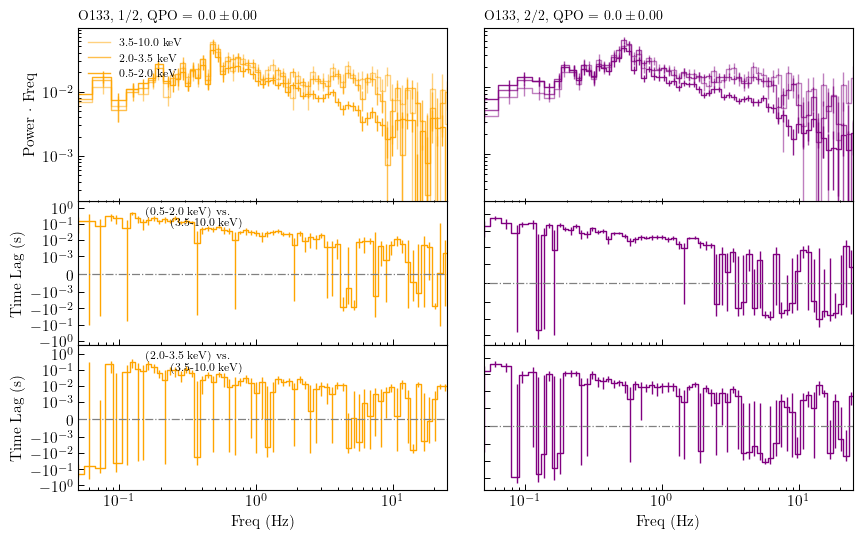

In [304]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

save_path_TL = 'Data/GX339/with_nicerl2/TimeLag/4133010102_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [0,1]: 
        
    if i == 0:
        mi, ma = 0,0
        color='orange'
    elif i == 1:
        mi, ma = 0,0
        color='purple'
    elif i == 2:
        mi, ma = 2.2,3.2
        color='limegreen'
    
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/2'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100)

## obs_id = 4133010103

In [65]:
obs_id = '4133010103'
lc_v = obs_v_GX[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 498.3, rms = 0.048, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 1105.5, rms = 0.092, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 781.4, rms = 0.131, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 323.6, rms = 0.168, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 159.3, rms = 0.202, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 101.8, rms = 0.220, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 65.6, rms = 0.231, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 42.9, rms = 0.216, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 28.2, rms = 0.237, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 19.0, rms = 0.226, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 13.2, rms = 0.246, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 9.3, rms = 0.235, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 6.5, rms = nan, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 4.2, rms = 0.175, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 2.8, rms = 0.242, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 3.1, rms = 0.260, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 1.3, rms = 0.370, dt = 0.005


lc_v[0].N/m =  149.31494140625 


Length of part:  38.0853271484375

Length of part:  47.87548828125

Length of part:  63.3538818359375


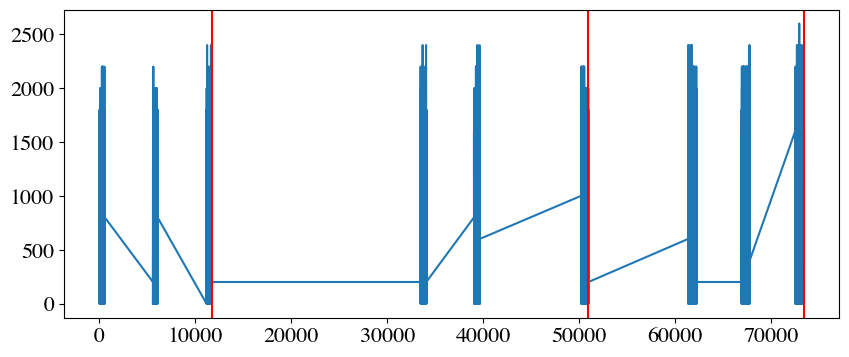

In [67]:
stops = [20000,55000]
#stops = [5000,10000,20000,37000,42000,55000,65000,70000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)


### Hardness ratio map

In [68]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v,obj='GX339')
clear_output()

### Time Lag

In [410]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [411]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(111399)
New part for time indices: (111399)-(208198)
New part for time indices: (208198)-(311995)
New part for time indices: (311995)-(431594)
New part for time indices: (431594)-(551392)
New part for time indices: (551392)-(704191)
New part for time indices: (704191)-(873990)
New part for time indices: (873990)-(1040389)
New part for time indices: (1040389)-(1223186)
New part for time indices: (0)-(111399)
New part for time indices: (111399)-(208198)
New part for time indices: (208198)-(311995)
New part for time indices: (311995)-(431594)
New part for time indices: (431594)-(551392)
New part for time indices: (551392)-(704191)
New part for time indices: (704191)-(873990)
New part for time indices: (873990)-(1040389)
New part for time indices: (1040389)-(1223186)
New part for time indices: (0)-(111399)
New part for time indices: (111399)-(208198)
New part for time indices: (208198)-(311995)
New part for time indices: (311995)-(431594)
New part for time i

In [412]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**12,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**12,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**12,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
0 of 27 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True

Power spectra done! 

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 23 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.41
Power spectra done! 

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise dist "Poisson"...
1 of 25 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.40
Power spectra done! 

Computing the power spectra using 4096 bins per segment, normalization "rms", and noise d

1 of 44 segments were disregarded due to lower percentage limit set to 95.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.43
Power spectra done! 



In [413]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,obj='GX339')


---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
1 of 714 segments were disregarded due to lower percentage limit set to 90.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.03
Power spectra done! 

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
1 of 714 segments were disregarded due to lower percentage limit set to 90.00%:
0 additional segments were used

Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy


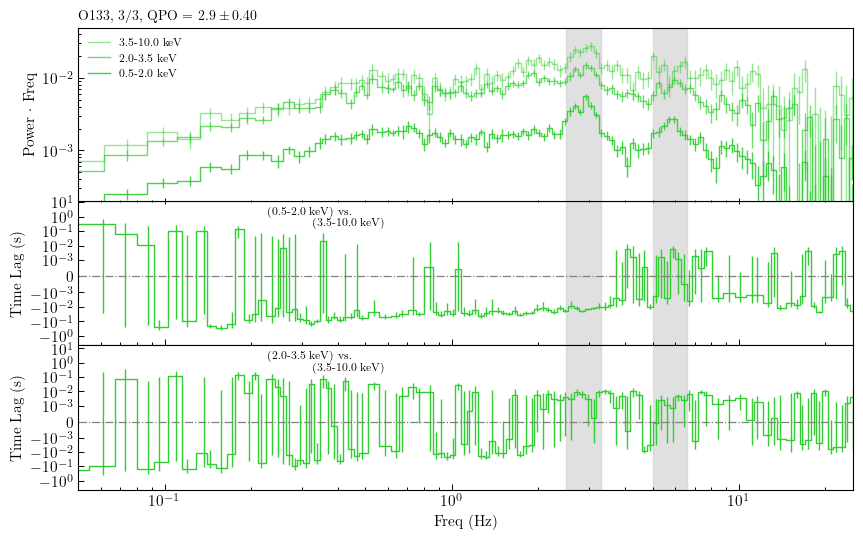

In [282]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

save_path_TL = 'Data/GX339/with_nicerl2/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [2]: 
        
    if i == 0:
        mi, ma = 1.85,2.3
        color='orange'
    elif i == 1:
        mi, ma = 2.3,3
        color='purple'
    elif i == 2:
        mi, ma = 2.5,3.3
        color='limegreen'
        
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/3'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=200)

### Different energy bands

In [620]:
part=0
obj = 'GX339'

Emin_v = [0.5,0.5,0.5,0.5,0.5,1,1,2,2]
Edivide_v = [1.5,2,2.5,3.5,5,3,5,3.5,5.5]

for Emin,Edivide in zip(Emin_v,Edivide_v):
    # Convert between energy and index for lightcurve starting at that energy 
    Edict = {}
    for i in range(0,len(lc_v)):
        Edict[0.5+0.5*i] = i

    # Pick out soft/hard
    lc_soft = merge_energies_lc(lc_v[Edict[Emin]:Edict[Edivide]])
    lc_hard = merge_energies_lc(lc_v[Edict[Edivide]:])

    # Check if already have done
    save_path_TL = "Data/{}/with_nicerl2/TimeLag/different_energy_bands/{}_{}-{}vs{}-{}keV_part{}.npy".format(obj,obs_id,lc_soft.Emin,lc_soft.Emax,lc_hard.Emin,lc_hard.Emax,part)
    try:
        np.load(save_path_TL,allow_pickle=True)
        already_done = True
    except FileNotFoundError:
        already_done = False
        pass
    
    if not already_done:
        # Pick out part
        lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
        lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

        # Just use one part
        lc_soft = lc_soft_parts[part]
        lc_hard = lc_hard_parts[part]

        # Find power spectra
        ps_soft = PowerSpectrum(lc_soft,m=2**13)
        ps_hard = PowerSpectrum(lc_hard,m=2**13)
        x = ps_soft.xf
        ps_s_save = [ps_soft.fft_rate, ps_soft.fft_rate_err, ps_soft.Emin, ps_soft.Emax] #soft 
        ps_h_save = [ps_hard.fft_rate, ps_hard.fft_rate_err, ps_hard.Emin, ps_hard.Emax] #hard

        # Find timelag
        x0,t0,d0 = time_lag([lc_soft,lc_hard], [2**8,2**12,2**14], auto=True)
        tl = [x0,t0,d0]

        # Save
        np.save(save_path_TL,[x,ps_s_save,ps_h_save,tl])


Calculating the power spectra...
Current progress: 100.0%
Current run time:  0.06  minutes
Expected run time:  0.06  minutes
Percentage of filled time bins (segment 37): 100.00
2 of 38 segments were disregarded due to lower percentage limit set to 90.00%:
0 additional segments were used thanks to use_max_data == True
Seg nr = 13, Percentage of filled time bins = 0.81
Seg nr = 25, Percentage of filled time bins = 0.80
Power spectra done! 

---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise d

## obs_id = 4133010104

In [69]:
obs_id = '4133010104'
lc_v = obs_v_GX[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 568.9, rms = 0.037, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 1341.8, rms = 0.063, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 998.7, rms = 0.094, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 422.8, rms = 0.133, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 206.6, rms = 0.165, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 128.2, rms = 0.183, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 79.0, rms = 0.207, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 49.2, rms = 0.212, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 31.1, rms = 0.256, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 20.2, rms = 0.252, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 13.4, rms = 0.219, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 9.2, rms = 0.188, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 6.4, rms = 0.207, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 4.1, rms = 0.207, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 2.6, rms = 0.357, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 2.9, rms = 0.321, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 1.2, rms = 0.498, dt = 0.005


lc_v[0].N/m =  213.4990234375 


Length of part:  55.2974853515625

Length of part:  24.4866943359375

Length of part:  35.644287109375

Length of part:  49.3404541015625

Length of part:  48.7298583984375


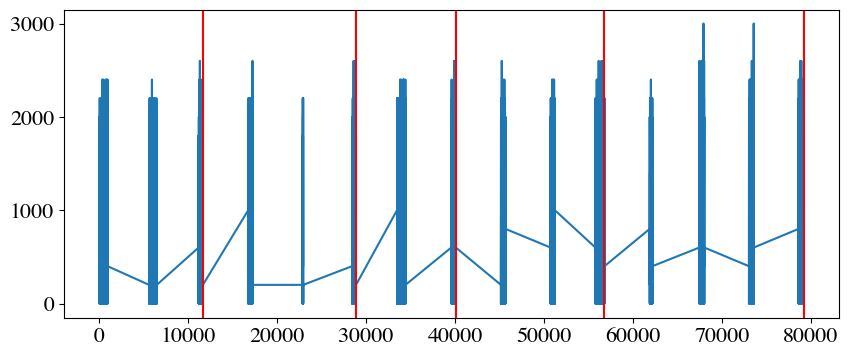

In [71]:
stops = [15000,30000,45000,60000]
#stops = [3000,10000,15000,20000,25000,32000,37000,42000,50000,55000,60000,65000,70000,76000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)


### Hardness ratio map

In [72]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v,obj='GX339')
clear_output()

### Time Lag

In [426]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [427]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(452997)
New part for time indices: (452997)-(653592)
New part for time indices: (653592)-(945590)
New part for time indices: (945590)-(1349787)
New part for time indices: (1349787)-(1748982)
New part for time indices: (0)-(452997)
New part for time indices: (452997)-(653592)
New part for time indices: (653592)-(945590)
New part for time indices: (945590)-(1349787)
New part for time indices: (1349787)-(1748982)
New part for time indices: (0)-(452997)
New part for time indices: (452997)-(653592)
New part for time indices: (653592)-(945590)
New part for time indices: (945590)-(1349787)
New part for time indices: (1349787)-(1748982)


In [429]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percentage_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 56 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 22, Percentage of filled time bins = 0.87
Seg nr = 44, Percentage of filled time bins = 0.86
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
3 of 26 segments were disregarded due to lower percentage limit set to 95.00%:
2 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.80
Seg nr = 12, Percentage of filled time bins = 0.72
Seg nr = 15, Percentage of filled time bins = 0.74
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 36 segments were disregarded due to lower percentage limit set to 95.00%:
1 additional segments

In [430]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,obj='GX339')


---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
4 of 1560 segments were disregarded due to lower percentage limit set to 90.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.03
Seg nr = 225, Percentage of filled time bins = 0.02
Seg nr = 653, Percentage of filled time bins = 0.03
Seg nr = 1083, Percentage of filled time bins = 0.03
Power spectra done! 

Computing the power spectra using 256 bins per segment, 

Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part3.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part4.npy


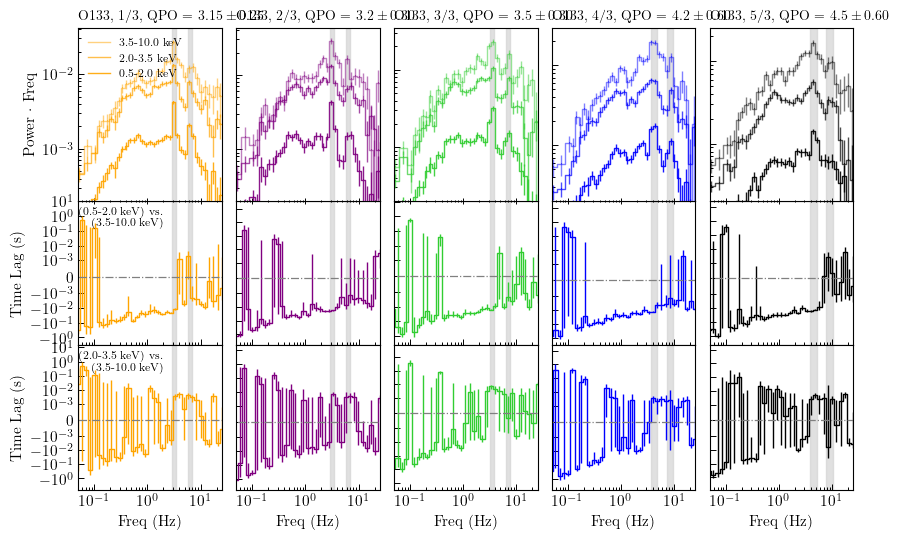

In [187]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

save_path_TL = 'Data/GX339/with_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [0,1,2,3,4]: 
        
    if i == 0:
        mi, ma = 2.9,3.4
        color='orange'
    elif i == 1:
        mi, ma =2.9,3.5
        color='purple'
    elif i == 2:
        mi, ma = 3.2,3.8
        color='limegreen'
    elif i == 3:
        mi, ma = 3.6,4.8
        color='b'
    elif i == 4:
        mi, ma = 3.9,5.1
        color='k'
        
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/3'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=50)

## obs_id = 4133010105

In [73]:
obs_id = '4133010105'
lc_v = obs_v_GX[obs_id].lc_v
lc_v.sort(key=operator.attrgetter('deltaE','Emin')) #sort after Emin and then again after deltaE
for lc in lc_v:
    print('Emin = {}, Emax = {}, R = {:.1f}, rms = {:.3f}, dt = {:.3f}'.format(lc.Emin,lc.Emax,lc.R,lc.Fvar,lc.dt))

Emin = 0.5, Emax = 1.0, R = 672.5, rms = 0.038, dt = 0.005
Emin = 1.0, Emax = 1.5, R = 1727.0, rms = 0.029, dt = 0.005
Emin = 1.5, Emax = 2.0, R = 1393.1, rms = 0.049, dt = 0.005
Emin = 2.0, Emax = 2.5, R = 618.3, rms = 0.074, dt = 0.005
Emin = 2.5, Emax = 3.0, R = 307.3, rms = 0.090, dt = 0.005
Emin = 3.0, Emax = 3.5, R = 186.9, rms = 0.117, dt = 0.005
Emin = 3.5, Emax = 4.0, R = 110.1, rms = 0.140, dt = 0.005
Emin = 4.0, Emax = 4.5, R = 64.0, rms = 0.152, dt = 0.005
Emin = 4.5, Emax = 5.0, R = 37.2, rms = 0.167, dt = 0.005
Emin = 5.0, Emax = 5.5, R = 22.1, rms = 0.183, dt = 0.005
Emin = 5.5, Emax = 6.0, R = 13.6, rms = 0.183, dt = 0.005
Emin = 6.0, Emax = 6.5, R = 8.7, rms = 0.233, dt = 0.005
Emin = 6.5, Emax = 7.0, R = 5.7, rms = 0.268, dt = 0.005
Emin = 7.0, Emax = 7.5, R = 3.4, rms = nan, dt = 0.005
Emin = 7.5, Emax = 8.0, R = 2.1, rms = 0.472, dt = 0.005
Emin = 8.0, Emax = 9.0, R = 2.2, rms = nan, dt = 0.005
Emin = 9.0, Emax = 10.0, R = 0.9, rms = nan, dt = 0.005


lc_v[0].N/m =  332.151123046875 


Length of part:  26.3668212890625

Length of part:  108.470703125

Length of part:  81.0299072265625

Length of part:  116.283447265625


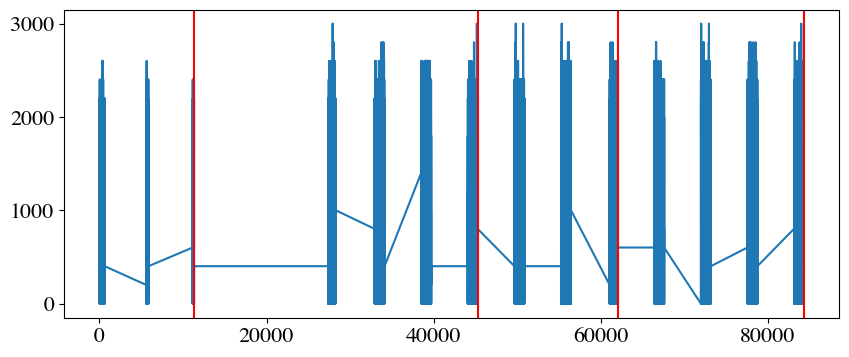

In [74]:
stops = [15000,48000,65000]
#stops = [3000,10000,15000,32000,37000,42000,48000,55000,60000,65000,70000,76000,80000] # for hardness map
m=2**13

print('lc_v[0].N/m = ',lc_v[0].N/m,'\n')
start_v, stop_v = find_where_to_split_lc(lc_v,stops)


### Hardness ratio map

In [75]:
save_for_hardness_map(obs_id,lc_v,start_v,stop_v,obj='GX339')
clear_output()

### Time Lag

In [292]:
lc_verysoft = merge_energies_lc(lc_v[0:3])
lc_soft = merge_energies_lc(lc_v[3:6])
lc_hard = merge_energies_lc(lc_v[6:17])

Initializing with lc in 0.5-1.0 keV
Merging with lc in 1.0-1.5 keV
Merging with lc in 1.5-2.0 keV
Initializing with lc in 2.0-2.5 keV
Merging with lc in 2.5-3.0 keV
Merging with lc in 3.0-3.5 keV
Initializing with lc in 3.5-4.0 keV
Merging with lc in 4.0-4.5 keV
Merging with lc in 4.5-5.0 keV
Merging with lc in 5.0-5.5 keV
Merging with lc in 5.5-6.0 keV
Merging with lc in 6.0-6.5 keV
Merging with lc in 6.5-7.0 keV
Merging with lc in 7.0-7.5 keV
Merging with lc in 7.5-8.0 keV
Merging with lc in 8.0-9.0 keV
Merging with lc in 9.0-10.0 keV


In [293]:
lc_verysoft_parts = [split_time_lc(lc_verysoft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_soft_parts = [split_time_lc(lc_soft,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]
lc_hard_parts = [split_time_lc(lc_hard,equal=False,start=start,stop=stop) for start,stop in zip(start_v,stop_v)]

New part for time indices: (0)-(215997)
New part for time indices: (215997)-(1104589)
New part for time indices: (1104589)-(1768386)
New part for time indices: (1768386)-(2720980)
New part for time indices: (0)-(215997)
New part for time indices: (215997)-(1104589)
New part for time indices: (1104589)-(1768386)
New part for time indices: (1768386)-(2720980)
New part for time indices: (0)-(215997)
New part for time indices: (215997)-(1104589)
New part for time indices: (1104589)-(1768386)
New part for time indices: (1768386)-(2720980)


In [ ]:
ps_verysoft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percent_limit=95) for lc in lc_verysoft_parts]
ps_soft_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percent_limit=95) for lc in lc_soft_parts]
ps_hard_parts = [PowerSpectrum(lc,m=2**13,timer_on=False,percent_limit=95) for lc in lc_hard_parts]

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
2 of 27 segments were disregarded due to lower percent limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 15, percent of filled time bins = 0.82
Seg nr = 23, percent of filled time bins = 0.77
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
5 of 109 segments were disregarded due to lower percent limit set to 95.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 0, percent of filled time bins = 0.25
Seg nr = 21, percent of filled time bins = 0.87
Seg nr = 50, percent of filled time bins = 0.92
Seg nr = 79, percent of filled time bins = 0.93
Seg nr = 80, percent of filled time bins = 80.36
Power spectra done! 

Computing the power spectra using 8192 bins per segment, normalization "rms", and noise dist "Poisson"...
3 of 82 segments were d

In [430]:
save_path_TL = save_timelag(obs_id,lc_verysoft_parts,lc_soft_parts,lc_hard_parts,ps_verysoft_parts,ps_soft_parts,ps_hard_parts,obj='GX339')


---------------------------------------------------------------------------------------------------
                           Computing the time lag...
---------------------------------------------------------------------------------------------------

Iteration 1) Computing using m = 256 bins per segment, i.e. f in [0.781,100.000]
---------------------------------------------------------------------------------------------------
Computing the cross spectrum...

Computing the power spectra using 256 bins per segment, normalization "None", and noise dist "None"...
4 of 1560 segments were disregarded due to lower percentage limit set to 90.00%:
1 additional segments were used thanks to use_max_data == True
Seg nr = 0, Percentage of filled time bins = 0.03
Seg nr = 225, Percentage of filled time bins = 0.02
Seg nr = 653, Percentage of filled time bins = 0.03
Seg nr = 1083, Percentage of filled time bins = 0.03
Power spectra done! 

Computing the power spectra using 256 bins per segment, 

Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part3.npy
Loading from  ../../Data/GX339/using_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part4.npy


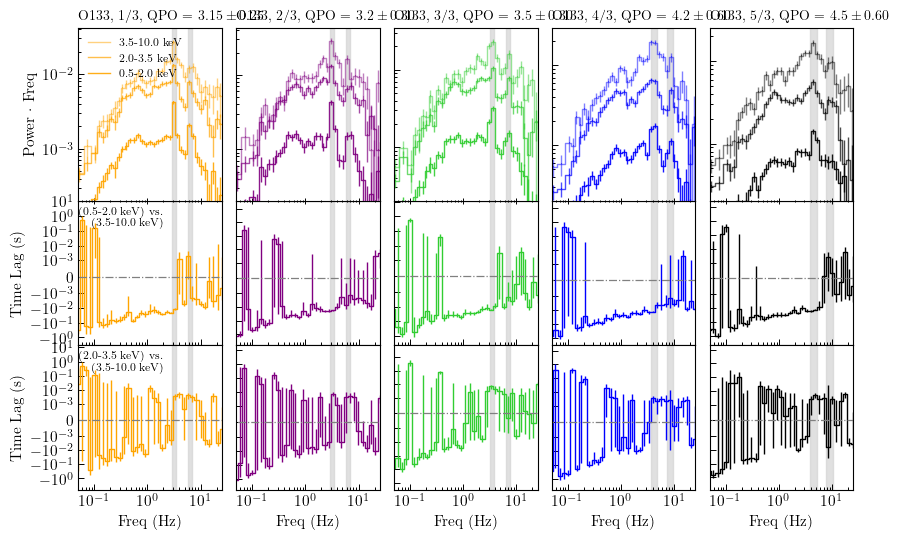

In [187]:
filenames = []
color_v = []
mi_v = []
ma_v = []
titles = []

save_path_TL = 'Data/GX339/with_nicerl2/TimeLag/4133010104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV'

for i in [0,1,2,3,4]: 
        
    if i == 0:
        mi, ma = 2.9,3.4
        color='orange'
    elif i == 1:
        mi, ma =2.9,3.5
        color='purple'
    elif i == 2:
        mi, ma = 3.2,3.8
        color='limegreen'
    elif i == 3:
        mi, ma = 3.6,4.8
        color='b'
    elif i == 4:
        mi, ma = 3.9,5.1
        color='k'
        
    filenames.append(save_path_TL+'_part{}.npy'.format(i))
    titles.append('O{}, {}/3'.format(save_path_TL[40:43],i+1))
    color_v.append(color)
    mi_v.append(mi)
    ma_v.append(ma)
    
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=50)

sd

# Figures for article?

## MAXI J1535 evolution

Loading from  Data/MAXIJ1535_571/TimeLag/1050360103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  Data/MAXIJ1535_571/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  Data/MAXIJ1535_571/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/1050360110_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy
Saving:  figures/MAXIJ1535_harmonic_evolution_5.pdf


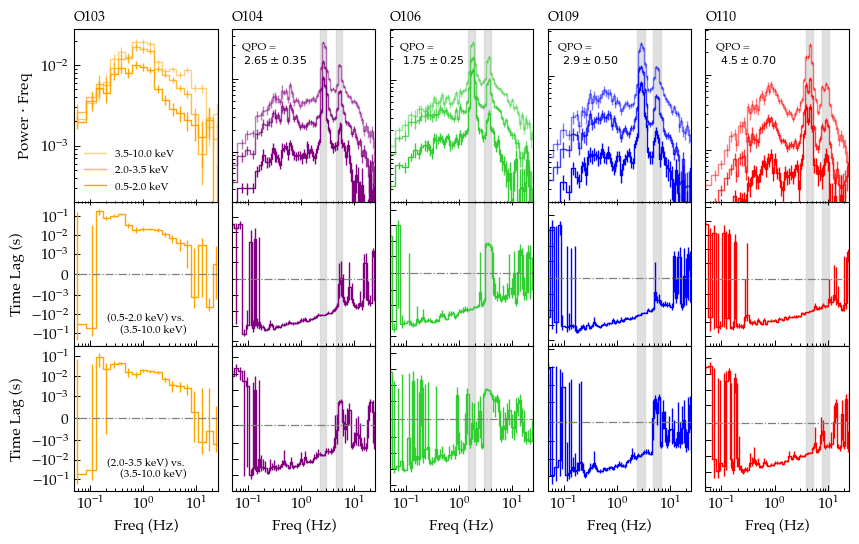

In [24]:
"""
filenames = ['../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360107_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy']
"""
filenames = ['Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy', \
            'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy', \
            'Data/MAXIJ1535_571/with_nicerl2/TimeLag/1050360110_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy']

color_v = ['orange','purple','limegreen','blue','red']
mi_v = [0,2.3,1.5,2.4,3.8]
ma_v = [0,3,2,3.4,5.2]
titles = ['O103','O104','O106','O109','O110']
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100,save='figures/MAXIJ1535_harmonic_evolution_5.pdf')
#power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100,third=True)

## GX339

Loading from  Data/GX339/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy


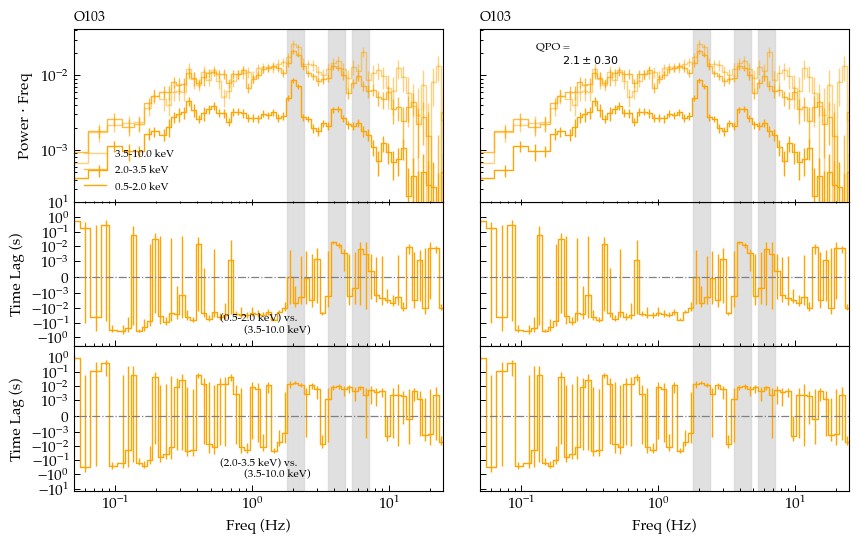

In [25]:
filenames = ['Data/GX339/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy',\
             'Data/GX339/TimeLag/4133010103_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy']

color_v = ['orange','orange']
mi_v = [1.8,1.8]
ma_v = [2.4,2.4]
titles = ['O103','O103']
power_and_timelag_plot(filenames,titles,color_v,mi_v,ma_v,num=100,third=True)

## Diff energies MAXI J1535

Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-1.5vs1.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-2.0vs2.0-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_2.0-5.5vs5.5-10.0keV_part1.npy


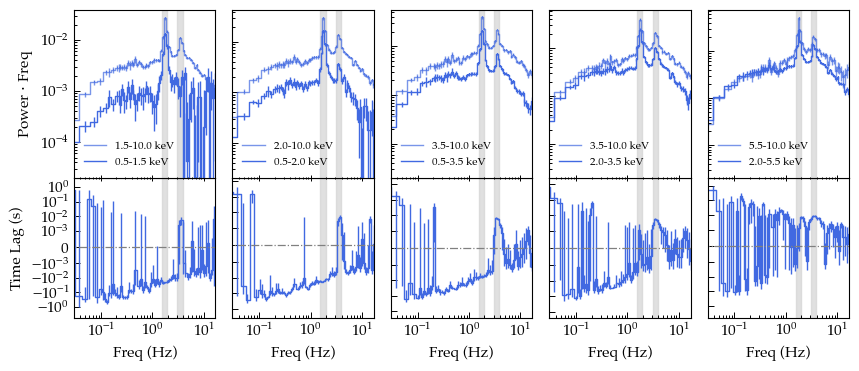

In [27]:
files = glob.glob('Data/MAXIJ1535_571/with_nicerl2/TimeLag/different_energy_bands/1050360106_*.npy')
files.sort()
files = [files[i] for i in [0,1,3,-2,-1]] #keep these energies

mi,ma,color,third,num,lw = 1.55,1.95,'royalblue',0,101,1.0

fig = plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 11})
gs = fig.add_gridspec(nrows=11,ncols=5,hspace=0,wspace=0.12)

start = 0 
for i,f in enumerate(files):

    # Variables 
    print('Loading from ',f)

    [x,ps_s_save,ps_h_save,tl] = np.load(f,allow_pickle=True)
    
    # Initialize col i
    #print(start,start+6,i%3)
    ax0 = fig.add_subplot(gs[start:start+6,i%5])
    ax1 = fig.add_subplot(gs[start+6:start+11,i%5],sharex=ax0)

    # Do for both subplots
    for ax in [ax0,ax1]: 
        ax.label_outer()
        ax.set_xscale('log')
        if mi != ma:
            ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
            ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
            if third == True:
                ax.axvspan(mi*3,ma*3,color='lightgray',alpha=0.7)

        ax.tick_params(which='minor',length=2,width=0.7)
        ax.tick_params(which='major',length=4,width=0.7)
        
    # Fix axis 0 
    plt.sca(ax0)
    Emin_v, Emax_v = [], []
    for ps,alp in zip([ps_h_save,ps_s_save],[0.7,1.0]):

        p,p_err,Emin,Emax = ps[0],ps[1],ps[2],ps[3]

        Emin_v.append(Emin)
        Emax_v.append(Emax)

        molb, fPf, fPferr = log_rebin(x, p*x, p_err*x, num=num) 
        label = '{}-{} keV'.format(Emin,Emax)
        ax0.step(molb, fPf, where='mid',color=color,label=label,alpha=alp,linewidth=lw)
        ax0.errorbar(molb, fPf, fPferr, fmt=',',color=color,alpha=alp,linewidth=lw)

        # Also good spot to place text:

    plt.legend(frameon=False,loc='lower left',fontsize=8)
    #plt.title(titles[i],loc='left',fontsize=10,fontweight="bold")
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim(x[0],x[-1]) # fix x-limits of axis so that the following don't mess it up
    #ax0.set_ylim(0.0004,0.006) # fix x-limits of axis so that the following don't mess it up
    ax0.tick_params(axis='x',which='both',direction='inout')
    ax0.tick_params(axis='y',which='both',direction='in')
    ax0.tick_params(which='minor',length=2,width=0.7)
    ax0.tick_params(which='major',length=4,width=0.7)
    ax0.zorder = 1 #to make ticks visible 

    # Fix axis 1
    x0,t0,d0 = tl 
    x,t,d = log_rebin(x0,t0,d0,num=num)
    ax1.step(x,-t,color,where='mid',linewidth=lw)
    ax1.errorbar(x,-t,yerr=d,fmt='.',color=color,markersize=0,capsize=0,linewidth=lw)
    ax1.tick_params(which='both',direction='in')
    ax1.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
    ax1.set_yscale('symlog', linthresh=0.001)

    #ax1.text(0.3,0.93,'({}-{} keV) vs.'.format(Emin_v.pop(0),Emax_v.pop(0)),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    #ax1.text(0.35,0.85,'({}-{} keV)'.format(Emin_v[-1],Emax_v[-1]),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax0.set_ylim(bottom=0.00002)
    ax0.set_xlim([0.03,17])
    ax1.set_xlim([0.03,17])

    if i == 0:
        ax0.set_ylabel('Power $\cdot$ Freq')
        ax1.set_ylabel('Time Lag (s)')
        
    ax1.set_xlabel('Freq (Hz)')

    #if i%3 == 2:
    #    start += 12
        
    save='figures/MAXIJ1535_obs106_diffenergybands_small.pdf'

plt.savefig(save,bbox_inches='tight',format="pdf")     
plt.show()

Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-1.5vs1.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-2.0vs2.0-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-2.5vs2.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_0.5-5.0vs5.0-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_1.0-3.0vs3.0-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_1.0-5.0vs5.0-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_2.0-3.5vs3.5-10.0keV_part1.npy
Loading from  Data/MAXIJ1535_571/TimeLag/different_energy_bands/1050360106_2.0-5.5vs5.5-10.0keV_part1.npy


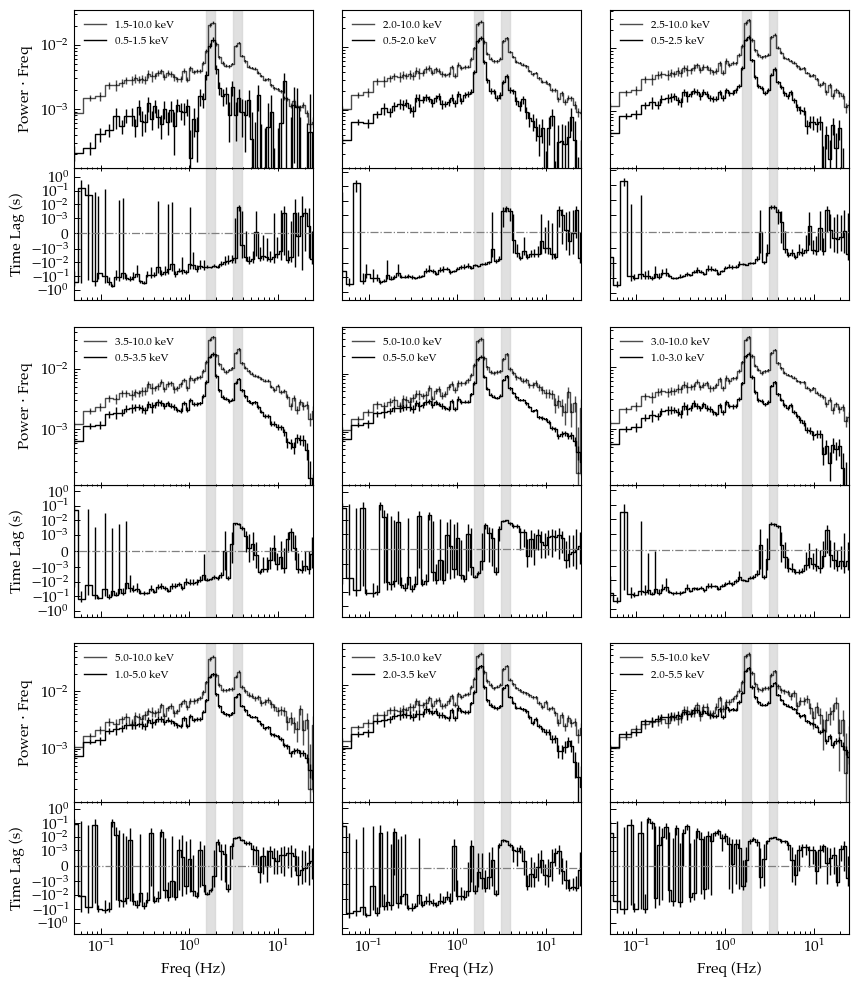

In [28]:
files = glob.glob('Data/MAXIJ1535_571/with_nicerl2/TimeLag/different_energy_bands/1050360106_*.npy')
files.sort()

mi,ma,color,third,num,lw = 1.55,1.95,'k',0,100,1.0

fig = plt.figure(figsize=(10,12))
plt.rcParams.update({'font.size': 11})
gs = fig.add_gridspec(nrows=35,ncols=3,hspace=0,wspace=0.12)

start = 0 
for i,f in enumerate(files):

    # Variables 
    print('Loading from ',f)

    [x,ps_s_save,ps_h_save,tl] = np.load(f,allow_pickle=True)
    
    # Initialize col i
    #print(start,start+6,i%3)
    ax0 = fig.add_subplot(gs[start:start+6,i%3])
    ax1 = fig.add_subplot(gs[start+6:start+11,i%3],sharex=ax0)

    # Do for both subplots
    for ax in [ax0,ax1]:
        ax.label_outer()
        ax.set_xscale('log')
        if mi != ma:
            ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
            ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
            if third == True:
                ax.axvspan(mi*3,ma*3,color='lightgray',alpha=0.7)

        ax.tick_params(which='minor',length=2,width=0.7)
        ax.tick_params(which='major',length=4,width=0.7)

    # Fix axis 0 
    plt.sca(ax0)
    Emin_v, Emax_v = [], []
    for ps,alp in zip([ps_h_save,ps_s_save],[0.7,1.0]):

        p,p_err,Emin,Emax = ps[0],ps[1],ps[2],ps[3]

        Emin_v.append(Emin)
        Emax_v.append(Emax)

        molb, fPf, fPferr = log_rebin(x, p*x, p_err*x, num=num) 
        label = '{}-{} keV'.format(Emin,Emax)
        ax0.step(molb, fPf, where='mid',color=color,label=label,alpha=alp,linewidth=lw)
        ax0.errorbar(molb, fPf, fPferr, fmt=',',color=color,alpha=alp,linewidth=lw)

        # Also good spot to place text:

    plt.legend(frameon=False,loc='upper left',fontsize=8)
    #plt.title(titles[i],loc='left',fontsize=10,fontweight="bold")
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim(x[0],x[-1]) # fix x-limits of axis so that the following don't mess it up
    #ax0.set_ylim(0.0004,0.006) # fix x-limits of axis so that the following don't mess it up
    ax0.tick_params(axis='x',which='both',direction='inout')
    ax0.tick_params(axis='y',which='both',direction='in')
    ax0.tick_params(which='minor',length=2,width=0.7)
    ax0.tick_params(which='major',length=4,width=0.7)
    ax0.zorder = 1 #to make ticks visible 

    # Fix axis 1
    x0,t0,d0 = tl 
    x,t,d = log_rebin(x0,t0,d0,num=num)
    ax1.step(x,-t,color,where='mid',linewidth=lw)
    ax1.errorbar(x,-t,yerr=d,fmt='.',color=color,markersize=0,capsize=0,linewidth=lw)
    ax1.tick_params(which='both',direction='in')
    ax1.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
    ax1.set_yscale('symlog', linthresh=0.001)

    #ax1.text(0.3,0.93,'({}-{} keV) vs.'.format(Emin_v.pop(0),Emax_v.pop(0)),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    #ax1.text(0.35,0.85,'({}-{} keV)'.format(Emin_v[-1],Emax_v[-1]),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax0.set_ylim(bottom=0.00012)
    ax0.set_xlim([0.05,25])
    ax1.set_xlim([0.05,25])

    if i%3 == 0:
        ax0.set_ylabel('Power $\cdot$ Freq')
        ax1.set_ylabel('Time Lag (s)')
        
    if i >= 6:
        ax1.set_xlabel('Freq (Hz)')

    if i%3 == 2:
        start += 12
        
    save='figures/MAXIJ1535_obs106_diffenergybands.pdf'

plt.savefig(save,bbox_inches='tight',format="pdf")     
plt.show()

## Diff energies GX 339

Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_0.5-1.5vs1.5-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_0.5-2.0vs2.0-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_0.5-2.5vs2.5-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_0.5-3.5vs3.5-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_0.5-5.0vs5.0-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_1.0-3.0vs3.0-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_1.0-5.0vs5.0-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_2.0-3.5vs3.5-10.0keV_part0.npy
Loading from  Data/GX339/TimeLag/different_energy_bands/4133010103_2.0-5.5vs5.5-10.0keV_part0.npy


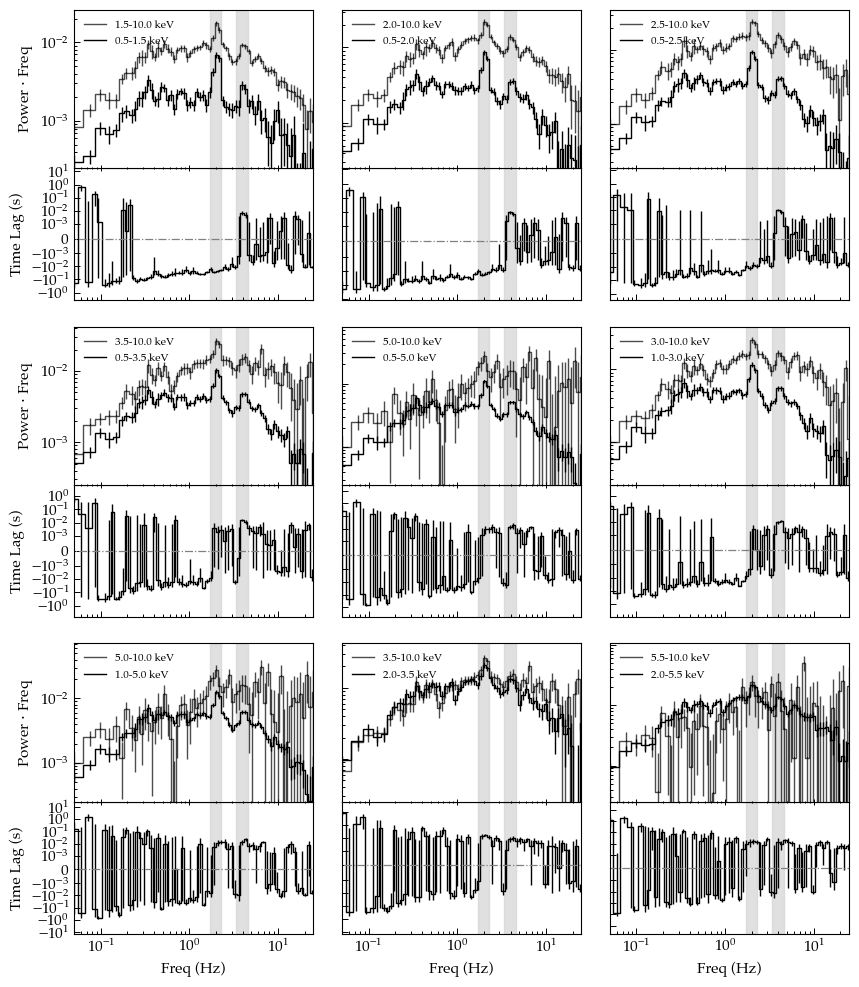

In [30]:
files = glob.glob('Data/GX339/with_nicerl2/TimeLag/different_energy_bands/4133010103_*.npy')
files.sort()

mi,ma,color,third,num,lw = 1.7,2.3,'k',0,100,1.0

fig = plt.figure(figsize=(10,12))
plt.rcParams.update({'font.size': 11})
gs = fig.add_gridspec(nrows=35,ncols=3,hspace=0,wspace=0.12)

start = 0 
for i,f in enumerate(files):

    # Variables 
    print('Loading from ',f)

    [x,ps_s_save,ps_h_save,tl] = np.load(f,allow_pickle=True)
    
    # Initialize col i
    #print(start,start+6,i%3)
    ax0 = fig.add_subplot(gs[start:start+6,i%3])
    ax1 = fig.add_subplot(gs[start+6:start+11,i%3],sharex=ax0)

    # Do for both subplots
    for ax in [ax0,ax1]:
        ax.label_outer()
        ax.set_xscale('log')
        if mi != ma:
            ax.axvspan(mi,ma,color='lightgray',alpha=0.7)
            ax.axvspan(mi*2,ma*2,color='lightgray',alpha=0.7)
            if third == True:
                ax.axvspan(mi*3,ma*3,color='lightgray',alpha=0.7)

        ax.tick_params(which='minor',length=2,width=0.7)
        ax.tick_params(which='major',length=4,width=0.7)

    # Fix axis 0 
    plt.sca(ax0)
    Emin_v, Emax_v = [], []
    for ps,alp in zip([ps_h_save,ps_s_save],[0.7,1.0]):

        p,p_err,Emin,Emax = ps[0],ps[1],ps[2],ps[3]

        Emin_v.append(Emin)
        Emax_v.append(Emax)

        molb, fPf, fPferr = log_rebin(x, p*x, p_err*x, num=num) 
        label = '{}-{} keV'.format(Emin,Emax)
        ax0.step(molb, fPf, where='mid',color=color,label=label,alpha=alp,linewidth=lw)
        ax0.errorbar(molb, fPf, fPferr, fmt=',',color=color,alpha=alp,linewidth=lw)

        # Also good spot to place text:

    plt.legend(frameon=False,loc='upper left',fontsize=8)
    #plt.title(titles[i],loc='left',fontsize=10,fontweight="bold")
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_xlim(x[0],x[-1]) # fix x-limits of axis so that the following don't mess it up
    #ax0.set_ylim(0.0004,0.006) # fix x-limits of axis so that the following don't mess it up
    ax0.tick_params(axis='x',which='both',direction='inout')
    ax0.tick_params(axis='y',which='both',direction='in')
    ax0.tick_params(which='minor',length=2,width=0.7)
    ax0.tick_params(which='major',length=4,width=0.7)
    ax0.zorder = 1 #to make ticks visible 

    # Fix axis 1
    x0,t0,d0 = tl 
    x,t,d = log_rebin(x0,t0,d0,num=num)
    ax1.step(x,-t,color,where='mid',linewidth=lw)
    ax1.errorbar(x,-t,yerr=d,fmt='.',color=color,markersize=0,capsize=0,linewidth=lw)
    ax1.tick_params(which='both',direction='in')
    ax1.plot([-10000,10000],[0,0],'-.',color='gray',linewidth=0.9)
    ax1.set_yscale('symlog', linthresh=0.001)

    #ax1.text(0.3,0.93,'({}-{} keV) vs.'.format(Emin_v.pop(0),Emax_v.pop(0)),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    #ax1.text(0.35,0.85,'({}-{} keV)'.format(Emin_v[-1],Emax_v[-1]),fontsize=8,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax0.set_ylim(bottom=0.00025)
    ax0.set_xlim([0.05,25])
    ax1.set_xlim([0.05,25])

    if i%3 == 0:
        ax0.set_ylabel('Power $\cdot$ Freq')
        ax1.set_ylabel('Time Lag (s)')
        
    if i >= 6:
        ax1.set_xlabel('Freq (Hz)')

    if i%3 == 2:
        start += 12
        
save='figures/GX339_obs103_diffenergybands.pdf'
plt.savefig(save,bbox_inches='tight',format="pdf")     
plt.show()

## Hardness-Intensity Maps

In [34]:
def obs_to_hardnessmap(idx,path):
    """Given list of observations, create hardness-intensity map."""
    
    obs_v = {} #initialize dictionary over observation-objects
    counts_2to7 = {} #number of counts between 2 and 7 keV
    counts_2to4 = {}
    counts_5to7 = {}
    
    for i in sorted(idx): 
        if i not in obs_v:
            obs_v[i] = observation(path+"{}/*.lc".format(i))
            
    for i,obs in obs_v.items():
        counts_2to7[i] = np.sum([lc.R for lc in obs.lc_v[3:13]])
        counts_2to4[i] = np.sum([lc.R for lc in obs.lc_v[3:7]])
        counts_5to7[i] = np.sum([lc.R for lc in obs.lc_v[9:13]])
        
    return counts_2to7, counts_2to4, counts_5to7

GX_339_id_v = ['3133010113','3558011501','4133010102','4133010103','4133010104','4133010105',\
        '4133010108','4133010119','4133010135',\
        '4133010152','4133010192','4675010603','4133010239','4133010243','4133010252',\
        '4675010701','4133010257','4133010273']

path = "Data/GX339/without_nicerl2/"

counts_2to7_GX_full, counts_2to4_GX_full, counts_5to7_GX_full = obs_to_hardnessmap(GX_339_id_v,path)

MAXIJ1535_id_v = ['1050360103','1050360104','1050360105','1050360106','1050360107','1050360108',\
        '1050360109','1050360110','1050360112',\
        '1050360120','1130360104','1130360112','1130360118',\
       '1130360127','1130360131','1130360156','1130360172']

path = "Data/MAXIJ1535_571/without_nicerl2/"

counts_2to7_MJ_full, counts_2to4_MJ_full, counts_5to7_MJ_full = obs_to_hardnessmap(MAXIJ1535_id_v,path)

if input('Clear all [y/n]: ') == 'y':
    clear_output()

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/3133010113/0.5to10keV.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/3133010113/0.5to10keV.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 0.5-10.0 keV created.
With parameters: N = 469597, dt = 0.005, R = 244.3, and Fvar = 0.4694.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing ligh

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 6.5-7.0 keV created.
With parameters: N = 469597, dt = 0.005, R = 1.337, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/3133010113/6to6.5kev.lc
-----------------------------------------------------------------------------------------------------------
L

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 2.0-2.5 keV created.
With parameters: N = 1511907, dt = 0.005, R = 135.3, and Fvar = 0.325.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/3558011501/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/3558011501/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_k

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 7.0-7.5 keV created.
With parameters: N = 1511907, dt = 0.005, R = 3.882, and Fvar = 0.3361.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/3558011501/8to9kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/3558011501/8to9kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys

Light curve object for GX339-4 in Eband = 7.5-8.0 keV created.
With parameters: N = 371999, dt = 0.005, R = 2.682, and Fvar = 0.7038.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010102/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010102/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 3.0-3.5 keV created.
With parameters: N = 1222186, dt = 0.005, R = 101.8, and Fvar = 0.2198.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010103/4.5to5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010103/4.5to5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 0.5-1.0 keV created.
With parameters: N = 1741778, dt = 0.005, R = 568.9, and Fvar = 0.03658.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010104/1.5to2kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010104/1.5to2kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 5.0-5.5 keV created.
With parameters: N = 1741778, dt = 0.005, R = 20.15, and Fvar = 0.257.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010104/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010104/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_k

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 2.5-3.0 keV created.
With parameters: N = 2716378, dt = 0.005, R = 307.3, and Fvar = 0.09061.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010105/2to2.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010105/2to2.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 7.5-8.0 keV created.
With parameters: N = 2716378, dt = 0.005, R = 2.107, and Fvar = 0.4769.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010105/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010105/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 3.5-4.0 keV created.
With parameters: N = 2014770, dt = 0.005, R = 132.5, and Fvar = 0.03639.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010108/3to3.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010108/3to3.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 8.0-9.0 keV created.
With parameters: N = 2014770, dt = 0.005, R = 1.597, and Fvar = 0.2102.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010108/9to10kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010108/9to10kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 5.5-6.0 keV created.
With parameters: N = 1285662, dt = 0.005, R = 9.761, and Fvar = 0.06243.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010119/5to5.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010119/5to5.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 1.0-1.5 keV created.
With parameters: N = 442541, dt = 0.005, R = 2.239e+03, and Fvar = 0.01355.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010135/2.5to3kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010135/2.5to3kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: d

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 9.0-10.0 keV created.
With parameters: N = 442541, dt = 0.005, R = 0.2025, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010152/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 7.5-8.0 keV created.
With parameters: N = 337398, dt = 0.005, R = 0.4582, and Fvar = 0.3614.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010152/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010152/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 4.0-4.5 keV created.
With parameters: N = 416169, dt = 0.005, R = 48.99, and Fvar = 0.09581.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010192/5.5to6kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010192/5.5to6kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 4.5-5.0 keV created.
With parameters: N = 188777, dt = 0.005, R = 4.372, and Fvar = 0.5136.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010239/4to4.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010239/4to4.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_k

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 0.5-1.0 keV created.
With parameters: N = 453194, dt = 0.005, R = 304.8, and Fvar = 0.005308.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010243/1.5to2kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010243/1.5to2kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 6.5-7.0 keV created.
With parameters: N = 453194, dt = 0.005, R = 0.1743, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010243/6to6.5kev.lc
-----------------------------------------------------------------------------------------------------------


NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 4.0-4.5 keV created.
With parameters: N = 281199, dt = 0.005, R = 4.872, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010252/5.5to6kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010252/5.5to6kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 2.5-3.0 keV created.
With parameters: N = 470192, dt = 0.005, R = 8.096, and Fvar = 0.341.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010257/2to2.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4133010257/2to2.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 9.0-10.0 keV created.
With parameters: N = 470192, dt = 0.005, R = 0.3024, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010273/10to15kev.lc
-----------------------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 6.0-6.5 keV created.
With parameters: N = 382268, dt = 0.005, R = 0.09051, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4133010273/7.5to8kev.lc
-----------------------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 5.0-5.5 keV created.
With parameters: N = 175199, dt = 0.005, R = 3.13, and Fvar = 0.3448.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4675010603/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4675010603/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for GX339-4 in Eband = 2.0-2.5 keV created.
With parameters: N = 169798, dt = 0.005, R = 43.86, and Fvar = 0.176.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/GX339/without_nicerl2/4675010701/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/GX339/without_nicerl2/4675010701/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for GX339-4 in Eband = 9.0-10.0 keV created.
With parameters: N = 169798, dt = 0.005, R = 0.2132, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360103/0.5to1kev.lc
---------------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 5.5-6.0 keV created.
With parameters: N = 26598, dt = 0.005, R = 83.45, and Fvar = 0.2795.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360103/5to5.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360103/5to5.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 1.0-1.5 keV created.
With parameters: N = 951388, dt = 0.005, R = 561.6, and Fvar = 0.06777.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360104/2.5to3kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360104/2.5to3kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys 

Light curve object for MAXIJ1535-571 in Eband = 8.0-9.0 keV created.
With parameters: N = 951388, dt = 0.005, R = 36.64, and Fvar = 0.2579.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360104/9to10kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360104/9to10kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 9.0-10.0 keV created.
With parameters: N = 951388, dt = 0.005, R = 15.64

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 4.5-5.0 keV created.
With parameters: N = 1932519, dt = 0.005, R = 313.8, and Fvar = 0.2087.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360105/4to4.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360105/4to4.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys 

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 8.0-12.0 keV created.
With parameters: N = 1932519, dt = 0.005, R = 63.8, and Fvar = 0.2107.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360105/8to9kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360105/8to9kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 4.5-5.0 keV created.
With parameters: N = 1121590, dt = 0.005, R = 306.9, and Fvar = 0.2082.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360106/4to4.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360106/4to4.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys 

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 2.0-2.5 keV created.
With parameters: N = 309199, dt = 0.005, R = 1.563e+03, and Fvar = 0.1209.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360107/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360107/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 1.5-2.0 keV created.
With parameters: N = 667569, dt = 0.005, R = 2.085e+03, and Fvar = 0.08694.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360108/1to1.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360108/1to1.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The k

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 6.0-6.5 keV created.
With parameters: N = 667569, dt = 0.005, R = 130.4, and Fvar = 0.2146.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360108/7.5to8kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360108/7.5to8kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 4.5-5.0 keV created.
With parameters: N = 804390, dt = 0.005, R = 433.1, and Fvar = 0.1866.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360109/4to4.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360109/4to4.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 1.5-2.0 keV created.
With parameters: N = 612192, dt = 0.005, R = 2.72e+03, and Fvar = 0.06453.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360110/1to1.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360110/1to1.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The ke

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 7.5-8.0 keV created.
With parameters: N = 612192, dt = 0.005, R = 46.14, and Fvar = 0.1873.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360110/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360110/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 5.5-6.0 keV created.
With parameters: N = 533594, dt = 0.005, R = 293.0, and Fvar = 0.09359.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360112/5to5.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360112/5to5.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys 

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 2.0-2.5 keV created.
With parameters: N = 714391, dt = 0.005, R = 3.263e+03, and Fvar = 0.01299.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1050360120/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1050360120/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The k

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 9.0-10.0 keV created.
With parameters: N = 714391, dt = 0.005, R = 10.54, and Fvar = 0.1835.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360104/0.5to1kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360104/0.5to1kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys 

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 7.5-8.0 keV created.
With parameters: N = 299800, dt = 0.005, R = 37.17, and Fvar = 0.2057.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360104/7to7.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360104/7to7.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 5.0-5.5 keV created.
With parameters: N = 687196, dt = 0.005, R = 244.8, and Fvar = 0.1702.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360112/6.5to7kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360112/6.5to7kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 2.0-2.5 keV created.
With parameters: N = 911109, dt = 0.005, R = 454.3, and Fvar = 0.0239.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360118/3.5to4kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360118/3.5to4kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys t

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 7.5-8.0 keV created.
With parameters: N = 911109, dt = 0.005, R = 0.2533, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360118/7to7.5kev.lc
----------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

Light curve object for MAXIJ1535-571 in Eband = 3.5-4.0 keV created.
With parameters: N = 1626389, dt = 0.005, R = 140.7, and Fvar = 0.01332.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360127/3to3.5kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360127/3to3.5kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 8.0-9.0 keV created.
With parameters: N = 1626389, dt = 0.005, R = 0.2744, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360127/9to10kev.lc
----------------------------------------------------------------------------------------------

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 4.0-4.5 keV created.
With parameters: N = 1419786, dt = 0.005, R = 75.96, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360131/5.5to6kev.lc
-----------------------------------------------------------------------------------------------------------
Loading fits from filename:  Data/MAXIJ1535_571/without_nicerl2/1130360131/5.5to6kev.lc
There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 9.0-10.0 keV created.
With parameters: N = 1419786, dt = 0.005, R = 0.06339, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360156/0.5to1kev.lc
-------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 6.5-7.0 keV created.
With parameters: N = 640778, dt = 0.005, R = 0.03184, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360156/6to6.5kev.lc
---------------------------------------------------------------------------------------------

There is no content-information for this fits.
Found key DATE-OBS in header0
Found key DATE-OBS in header1.
The keys to the data are: dict_keys(['TIME', 'RATE', 'ERROR', 'FRACEXP', 'OBJECT', 'DATE-OBS'])
Loading fits done. 

NOTE: The rms cannot be computed since signal-to-noise ratio is too low; the expectation value of the Poisson variance term is larger than the \measured average variance term, producing negative average excess variances.

Light curve object for MAXIJ1535-571 in Eband = 3.5-4.0 keV created.
With parameters: N = 702192, dt = 0.005, R = 0.09997, and Fvar = nan.
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
               Importing lightcurve from f = Data/MAXIJ1535_571/without_nicerl2/1130360172/3to3.5kev.lc
---------------------------------------------------------------------------------------------

Clear all [y/n]: n


index_v =  ['1050360103', '1050360104', '1050360105', '1050360106', '1050360107', '1050360108', '1050360109', '1050360110', '1050360112', '1050360120', '1130360104', '1130360112', '1130360118', '1130360127', '1130360131', '1130360156', '1130360172']
index_v =  ['3133010113', '3558011501', '4133010102', '4133010103', '4133010104', '4133010105', '4133010108', '4133010119', '4133010135', '4133010152', '4133010192', '4675010603', '4133010239', '4133010243', '4133010252', '4675010701', '4133010257', '4133010273']


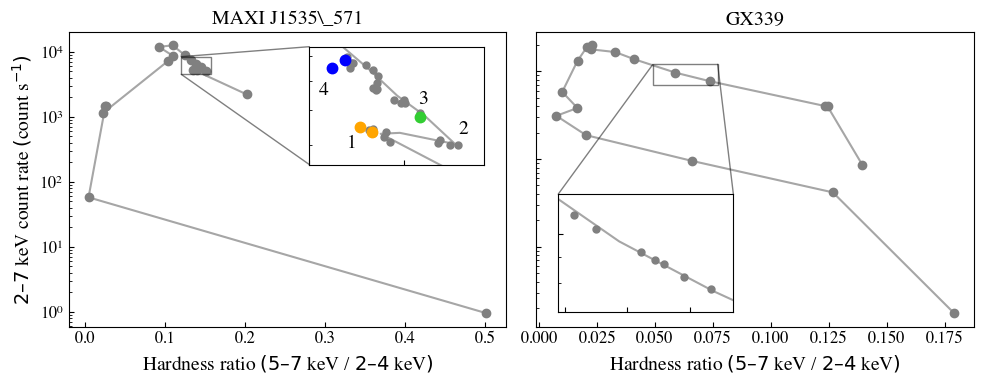

In [81]:
standard_plot(w=10,h=4,fontsize=12)

def plot_for_both(data,ax):
    
    index_v = data[0]
    counts_2to7 = data[1]
    counts_2to4 = data[2]
    counts_5to7 = data[3]
    
    print('index_v = ',index_v)
    
    x,y = [],[]
    for i in index_v: 
        x.append(counts_5to7[i]/counts_2to4[i])
        y.append(counts_2to7[i])
        #ax.annotate(obs_v[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7[i]/counts_2to4[i],counts_2to7[i]),fontsize=12)

    plt.semilogy(x,y,'-',color='gray',markersize=12,alpha=0.7)    
    plt.semilogy(x,y,'.',color='gray',markersize=12)
    
#    plt.semilogy(x[0],y[0],'.',color='limegreen',markersize=16)
#    plt.semilogy(x[-1],y[-1],'.',color='red',markersize=16)
    ax.set_xlabel('Hardness ratio $(5–7$ keV / $2–4$ keV$)$',fontsize=14)
    ax.set_ylabel('$2–7$ keV count rate $($count s$^{-1})$',fontsize=14)
    ax.tick_params(axis='both',which='both',direction='in')
    ax.label_outer()
    
    return x,y 

def fix_inserted(axins,ax,x1,x2,y1,y2,id_v,counts_5to7,counts_2to4,counts_2to7,x,y):
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    # sub region of the original image
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    ax.indicate_inset_zoom(axins, edgecolor="k")
    axins.semilogy(x,y,'-',color='gray',markersize=12,alpha=0.7)    
    
    x,y = [],[]
    for count,i in enumerate(id_v): 
        try:
            color = cmap(count*40)
            for part in range(1,15):
                key = i+'part{}'.format(part)
                
                # Unfortunately do this manually:
                """
                FOR THE CODE BELOW, WE ALSO NEED TO GO UP TO THE CORRESPONDING OBSERVATION
                AND SPLIT INTO SEVERAL PARTS AND THEN SAVE USING: 
                    save_for_hardness_map(obs_id,lc_v,start_v,stop_v)
                """
                
                if key == '1050360104part1' or key == '1050360104part2':
                    color = 'orange'
                elif key == '1050360106part4' or key == '1050360106part5' or key == '1050360106part6':
                    color = 'purple'
                elif key == '1050360107part1':
                    color = 'limegreen'
                elif key == '1050360109part3' or key == '1050360109part4':
                    color = 'b'
                else:
                    color = 'gray'
                
                
                x_temp = counts_5to7[key]/counts_2to4[key]
                y_temp = counts_2to7[key]
                x.append(x_temp)
                y.append(y_temp)
                if color == 'gray':
                    axins.semilogy(x_temp,y_temp,'.',color=color,markersize=10)
                else:
                    axins.semilogy(x_temp,y_temp,'.',color=color,markersize=15,zorder=10)
                #ax.annotate(obs_v[i].lc_v[0].DATEOBS[0:10]+' ({})'.format(i), (counts_5to7[i]/counts_2to4[i],counts_2to7[i]),fontsize=12)
        except KeyError:
            pass
        
    
    axins.set_yticklabels([], minor=True)
    axins.set_yticklabels([])
    axins.tick_params(axis='both',which='both',direction='in')


## -------- Load Data --------
    
GX = [GX_339_id_v, counts_2to7_GX_full, counts_2to4_GX_full, counts_5to7_GX_full]
MJ = [MAXIJ1535_id_v, counts_2to7_MJ_full, counts_2to4_MJ_full, counts_5to7_MJ_full]

## -------- ax1 --------

ax1 = plt.subplot(1,2,1)
x,y = plot_for_both(MJ,ax1)
ax1.set_title('MAXI J1535\_571')

# inset axes....
axins = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
x1, x2, y1, y2 = 0.12, 0.157, 4500, 8400
fix_inserted(axins,ax1,x1,x2,y1,y2,id_v_MJ,counts_5to7_MJ,counts_2to4_MJ,counts_2to7_MJ,x,y)
axins.text(0.128, 4900, '1',fontsize=14)
axins.text(0.1515, 5300, '2',fontsize=14)
axins.text(0.143, 6200, '3',fontsize=14)
axins.text(0.122, 6500, '4',fontsize=14)

## -------- ax2 --------

ax2 = plt.subplot(1,2,2)

x,y = plot_for_both(GX,ax2)
ax2.set_title('GX339')

# inset axes....
axins = ax2.inset_axes([0.05, 0.05, 0.4, 0.4])
x1, x2, y1, y2 = 0.049, 0.077, 700, 1200
fix_inserted(axins,ax2,x1,x2,y1,y2,id_v_GX,counts_5to7_GX,counts_2to4_GX,counts_2to7_GX,x,y)

## ----------------------
plt.tight_layout()
#plt.savefig('../../Figures_for_article/Hardness_map.pdf',bbox_inches='tight',format='pdf')
plt.show()


---

# Other investigations

## RMS

In [122]:
def find_average_timelag(tl,freq_low,freq_high):
        
    x0,t0,d0 = tl 
    xf,timelag,d = log_rebin(x0,-t0,d0,num=150) #need to use minus once from tl to get into the normal convention!
    
    # Find rms within the given interval
    xf,[timelag,d] = remove_freq(xf,[timelag,d],limit=freq_low,geq=True,disregard=True)    
    xf,[timelag,d] = remove_freq(xf,[timelag,d],limit=freq_high,leq=True,disregard=True)
    
    return np.mean(timelag), np.sqrt(np.sum(d**2))

def find_rms(xf,ps_v,freq_low,freq_high):
    
    ps,ps_err = ps_v[0],ps_v[1]
    
    xf,ps,ps_err = log_rebin(xf,ps,ps_err,num=150) #need to use minus once from tl to get into the normal convention!
    
    xf, [ps,ps_err] = remove_freq(xf,[ps,ps_err],limit=freq_low,geq=True,disregard=True)
    xf, [fft_rate,fft_rate_err] = remove_freq(xf,[ps,ps_err],limit=freq_high,leq=True,disregard=True)
    dnu = freq_high-freq_low

    rms = np.sqrt(dnu * np.mean(fft_rate)) #\approx same as Fvar_from_ps(xf,fft_rate)
    df = xf[1]-xf[0]
    rms_err = df*np.sqrt(np.sum(fft_rate_err**2))/(2*rms) #error propagation
    
    return rms, rms_err

def find_average_timelag_and_rms(filenames,mi_v,ma_v):
    QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict = {},{},{},{}
    
    # Find average time lag at QPO and harmonic 
    for f,mi,ma in zip(filenames,mi_v,ma_v): 
        [xf,ps_vs_save,ps_s_save,ps_h_save,timelag_vsh,timelag_sh] = np.load(f,allow_pickle=True)

        # QPO
        freq_low, freq_high = mi, ma
        rms_vs,rms_vs_err = find_rms(xf,ps_vs_save,freq_low,freq_high)
        rms_s,rms_s_err = find_rms(xf,ps_s_save,freq_low,freq_high)
        rms_h,rms_h_err = find_rms(xf,ps_h_save,freq_low,freq_high)

        rms_QPO_v = [rms_vs,rms_vs_err,rms_s,rms_s_err,rms_h,rms_h_err]
        tl_vsh,err_vsh = find_average_timelag(timelag_vsh,freq_low,freq_high)
        tl_sh,err_sh = find_average_timelag(timelag_sh,freq_low,freq_high)

        QPO_rms_dict[f] = rms_QPO_v
        QPO_timelag_dict[f] = [tl_vsh,err_vsh,tl_sh,err_sh]

        # Harmonic 
        freq_low, freq_high = mi*2, ma*2
        rms_vs,rms_vs_err = find_rms(xf,ps_vs_save,freq_low,freq_high)
        rms_s,rms_s_err = find_rms(xf,ps_s_save,freq_low,freq_high)
        rms_h,rms_h_err = find_rms(xf,ps_h_save,freq_low,freq_high)

        rms_v = [rms_vs,rms_vs_err,rms_s,rms_s_err,rms_h,rms_h_err]
        tl_vsh,err_vsh = find_average_timelag(timelag_vsh,freq_low,freq_high)
        tl_sh,err_sh = find_average_timelag(timelag_sh,freq_low,freq_high)

        HARM_rms_dict[f] = rms_v
        HARM_timelag_dict[f] = [tl_vsh,err_vsh,tl_sh,err_sh]

    return QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict
    
def plot_rms_timelag_freq(obj,filenames,mi_v,ma_v,QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict):
        
    standard_plot(w=10,h=12)

    # Fix colors
    cmap_m = cm.get_cmap('jet_r')
    mean_v = [np.mean([mi,ma]) for mi,ma in zip(mi_v,ma_v)] # Mean peak freq at QPO
    c_v = [cmap_m(m) for m in preprocessing.minmax_scale(mean_v, feature_range=(0,1))]

    # Create 3 axes
    ax1 = plt.subplot(3,1,1)
    ax2 = plt.subplot(3,1,2)
    ax3 = plt.subplot(3,1,3)

    x0,y0,y0_err,y0_QPO,y0_QPO_err = [],[],[],[],[]
    for f,c,m in zip(filenames,c_v,mean_v):
        # HARM_rms_dict[f] = [rms_vs,rms_vs_err,rms_s,rms_s_err,rms_h,rms_h_err]
        # HARM_timelag_dict[f] = [tl_vsh,err_vsh,tl_sh,err_sh] #averages

        r_v = HARM_rms_dict[f]
        a_v = HARM_timelag_dict[f] 
        a_QPO_v = QPO_timelag_dict[f]

        # vs mot hard
        ax1.errorbar(r_v[0],a_v[0],xerr=r_v[1],yerr=a_v[1],color=c,fmt='.',markersize=10) #very soft rms mot tl_vsh
        ax1.errorbar(r_v[4],a_v[0],xerr=r_v[5],yerr=a_v[1],color=c,fmt='d',markersize=10) #hard rms mot tl_vsh

        # s mot hard
        ax1.errorbar(r_v[2],a_v[2],xerr=r_v[3],yerr=a_v[3],color=c,fmt='^',markersize=10) #soft rms mot tl_sh
        ax1.errorbar(r_v[4],a_v[2],xerr=r_v[5],yerr=a_v[3],color=c,fmt='x',markersize=10) #hard rms mot tl_sh

        # To fix colorbar...
        x0.append(r_v[0])
        y0.append(a_v[0])
        y0_err.append(a_v[1])
        y0_QPO.append(a_QPO_v[0])
        y0_QPO_err.append(a_QPO_v[1])

        ax2.errorbar(m,a_v[0],yerr=a_v[1],color='b',fmt='.',markersize=10)
        ax2.errorbar(m,a_v[2],yerr=a_v[3],color='b',fmt='.',markersize=10,alpha=0.5)
        
        ax2.errorbar(m,a_QPO_v[0],yerr=a_QPO_v[1],color='g',fmt='.',markersize=10)
        ax2.errorbar(m,a_QPO_v[2],yerr=a_QPO_v[3],color='g',fmt='.',markersize=10,alpha=0.5)

    
    # ------------------ NOT SURE WHY THIS HAPPENS ------------------------------------
    
    # NEED TO RUN THIS LINE BELOW ONCE AND THEN REMOVE IT :)))))
    #cb = ax1.scatter(x0,y0,s=1,c=mean_v,cmap=cmap_m,vmin=np.amin(mean_v),vmax=np.amax(mean_v))
    
    # ------------------------------------------------------------------------------------------

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cb, cax=cax, orientation='vertical')
    ax1.set_yscale('symlog', linthresh=0.001) # Turn off and on! 
    ax1.set_xlabel('RMS')
    ax1.set_ylabel('Time Lag (s)')
    ax1.set_title('{}: harmonic (cb = QPO freq)'.format(obj))

    # TL vs QPO freq
    ax2.errorbar(m,HARM_timelag_dict[f][0],yerr=HARM_timelag_dict[f][1],color='b',fmt='.',markersize=10,label='Harmonic vs-h')
    ax2.errorbar(m,HARM_timelag_dict[f][2],yerr=HARM_timelag_dict[f][3],color='b',alpha=0.5,fmt='.',markersize=10,label='Harmonic s-h')
    ax2.errorbar(m,a_QPO_v[0],yerr=a_QPO_v[1],color='g',fmt='.',markersize=10,label='QPO vs-h')
    ax2.errorbar(m,a_QPO_v[2],yerr=a_QPO_v[3],color='g',alpha=0.5,fmt='.',markersize=10,label='QPO s-h')
    ax2.set_xlabel('QPO Freq')
    ax2.set_yscale('symlog', linthresh=0.001) # Turn off and on! 
    ax2.set_ylabel('Time Lag (s)')
    ax2.legend(fontsize=12)
    print('The two plots show different things... In first: time lag increase with freq (wrong?), in sec: tl decrease with freq (correct?)')

    # TL vs observations
    ax3.errorbar(np.linspace(1,len(y0),len(y0)),y0,yerr=y0_err,color='b',fmt='.',markersize=10,label='Harmonic vs-h')
    ax3.errorbar(np.linspace(1,len(y0_QPO),len(y0_QPO)),y0_QPO,yerr=y0_QPO_err,color='g',fmt='.',markersize=10,label='QPO vs-h')
    ax3.set_xlabel('Observations')
    ax3.set_yscale('symlog', linthresh=0.001) # Turn off and on! 
    ax3.set_ylabel('Time Lag (s)')
    ax3.legend(fontsize=12)

    plt.tight_layout()
    plt.show()    

The two plots show different things... In first: time lag increase with freq (wrong?), in sec: tl decrease with freq (correct?)


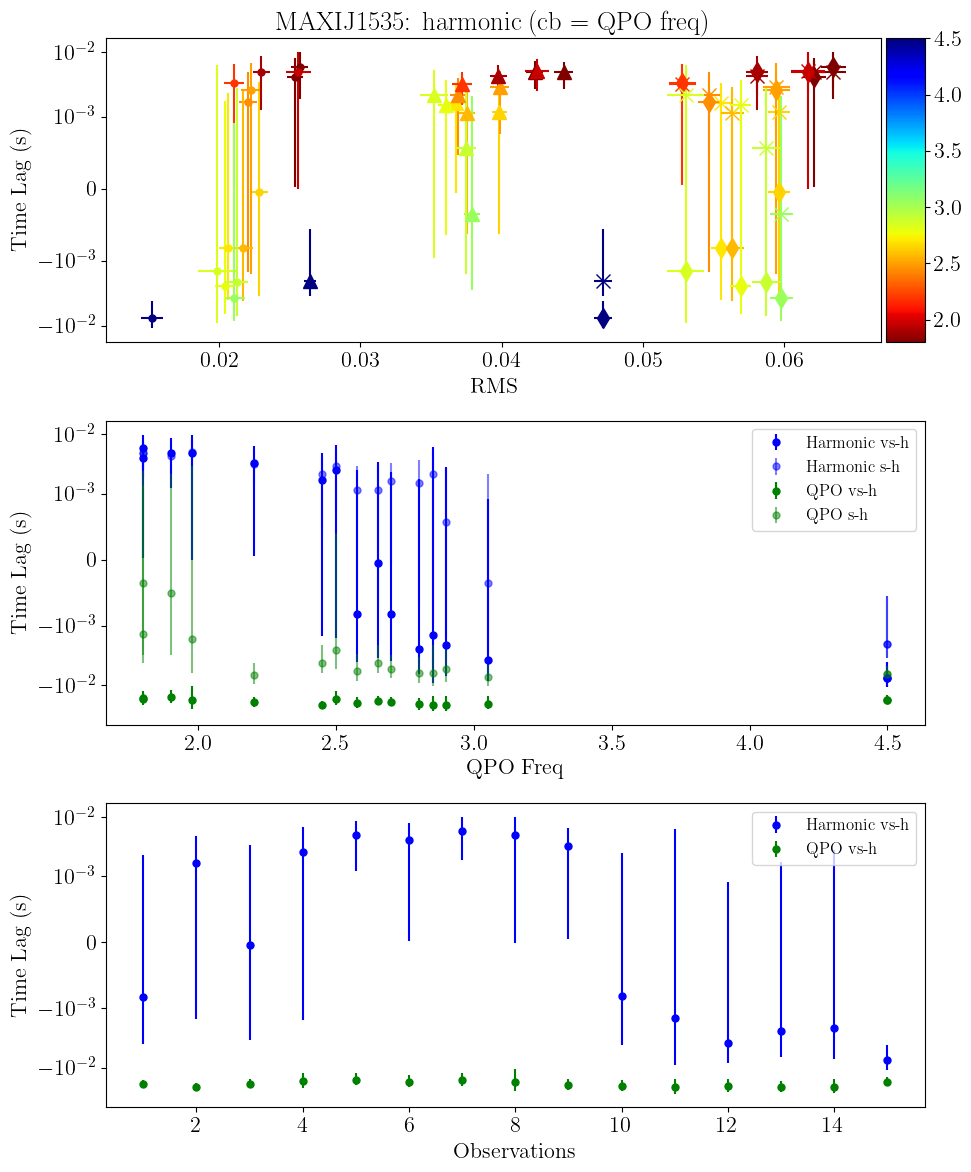

In [123]:
""" 
# Just a few
filenames = ['../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360104_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360105_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part2.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360106_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360107_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part0.npy', \
            '../../Data/MAXIJ1535_571/using_nicerl2/TimeLag/1050360109_0.5-2.0vs2.0-3.5keV_and_2.0-3.5vs3.5-10.0keV_part1.npy']

mi_v = [2.3,2.3,2.2,2.2,1.5,1.8,2.4]
ma_v = [3,3,2.8,3.2,2,2.4,3.4]
"""

# All
filenames = sorted(glob.glob('Data/MAXIJ1535_571/with_nicerl2/TimeLag/*.npy'))
mi_v = [2.4,2.2,2.3,2.2,1.7,1.6,1.6,1.75,2,2.25,2.5,2.5,2.4,2.5,3.8]
ma_v = [3,2.7,3,2.8,2.1,2,2,2.2,2.4,2.9,3.2,3.6,3.2,3.3,5.2]

QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict = find_average_timelag_and_rms(filenames,mi_v,ma_v)
plot_rms_timelag_freq('MAXIJ1535',filenames,mi_v,ma_v,QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict)


The two plots show different things... In first: time lag increase with freq (wrong?), in sec: tl decrease with freq (correct?)


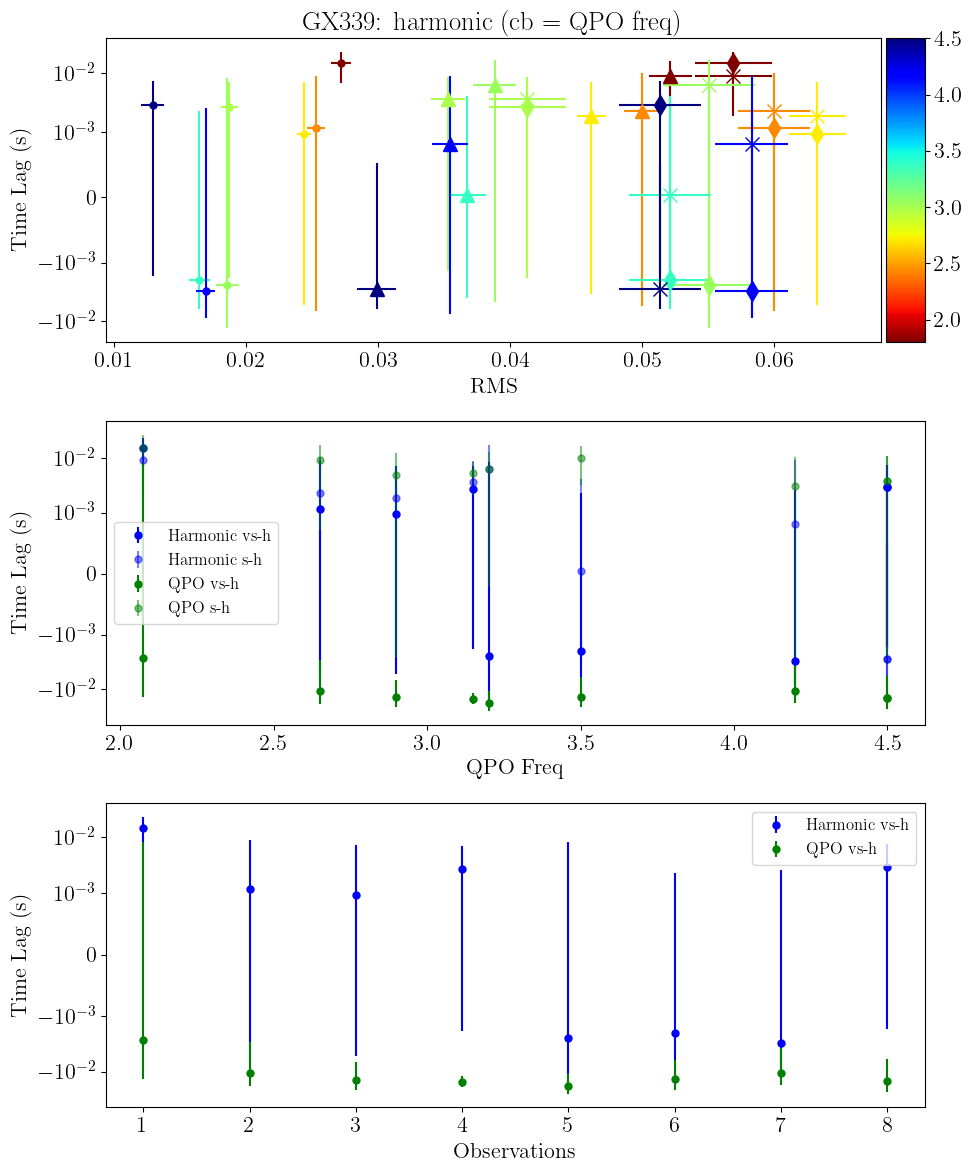

In [39]:
# All
filenames = sorted(glob.glob('../../Data/GX339/using_nicerl2/TimeLag/*.npy'))
filenames = filenames[2:]
# For observations 103 & 104 
mi_v = [1.85,2.3,2.5,2.9,2.9,3.2,3.6,3.9]
ma_v = [2.3,3,3.3,3.4,3.5,3.8,4.8,5.1]

QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict = find_average_timelag_and_rms(filenames,mi_v,ma_v)
plot_rms_timelag_freq('GX339',filenames,mi_v,ma_v,QPO_rms_dict, QPO_timelag_dict, HARM_rms_dict, HARM_timelag_dict)


## TimeLag vs Energy

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360104_part0_refband1.5_2.0keV.npy


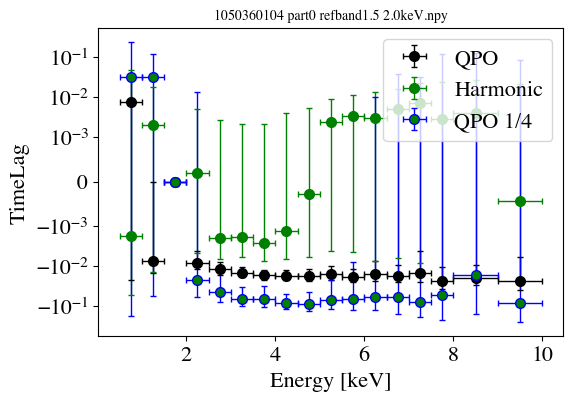

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360104_part0_refband4.0_4.5keV.npy


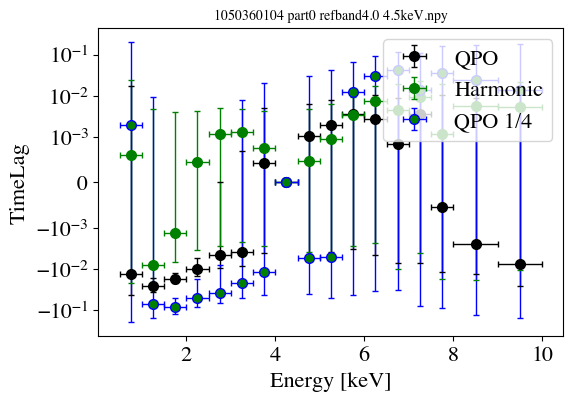

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360104_part1_refband1.5_2.0keV.npy


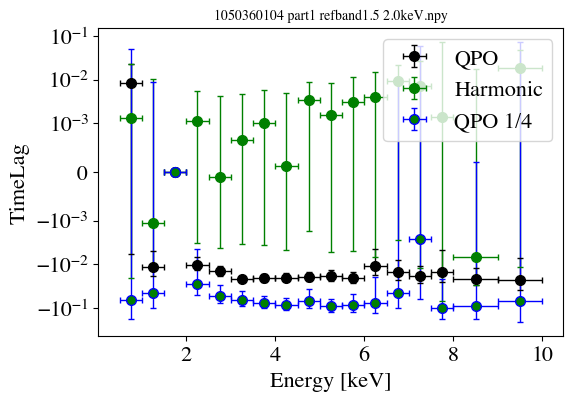

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360104_part1_refband4.0_4.5keV.npy


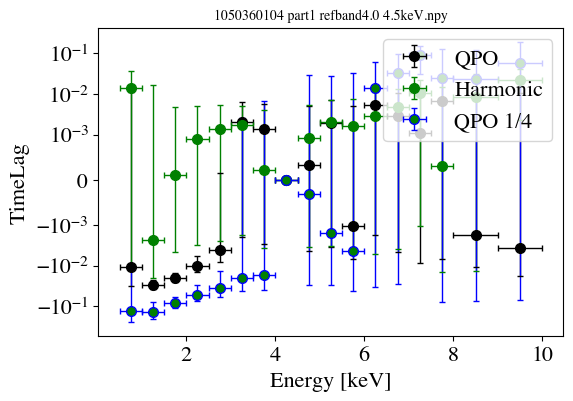

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part0_refband1.5_2.0keV.npy


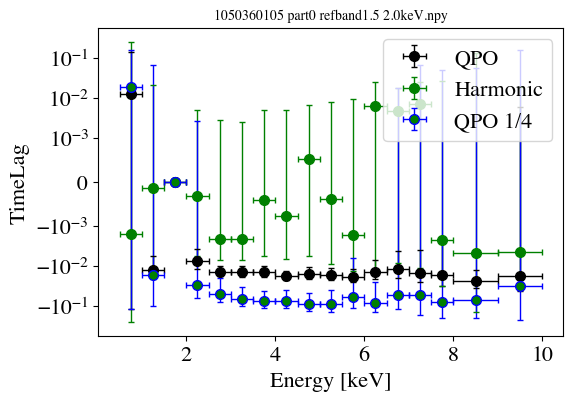

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part0_refband4.0_4.5keV.npy


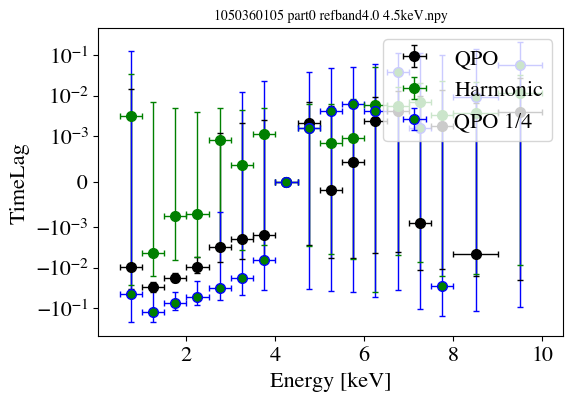

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part1_refband1.5_2.0keV.npy


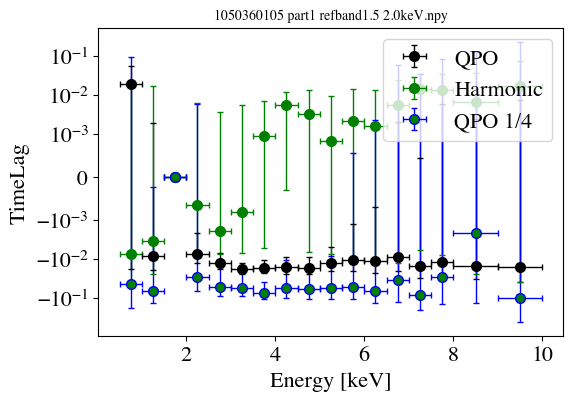

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part1_refband4.0_4.5keV.npy


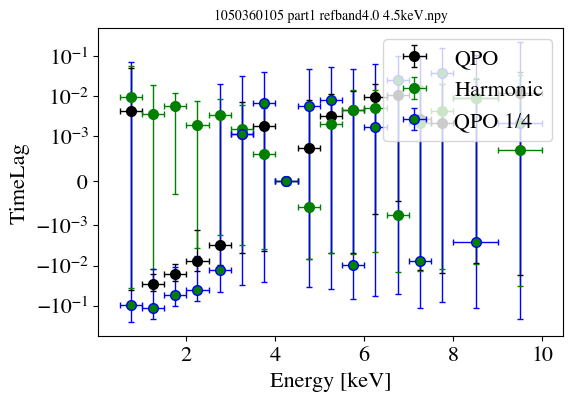

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part2_refband1.5_2.0keV.npy


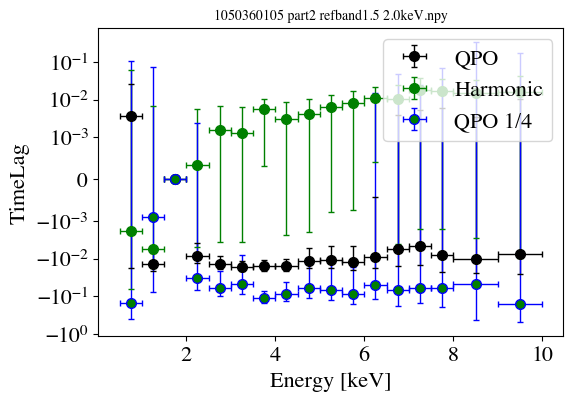

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360105_part2_refband4.0_4.5keV.npy


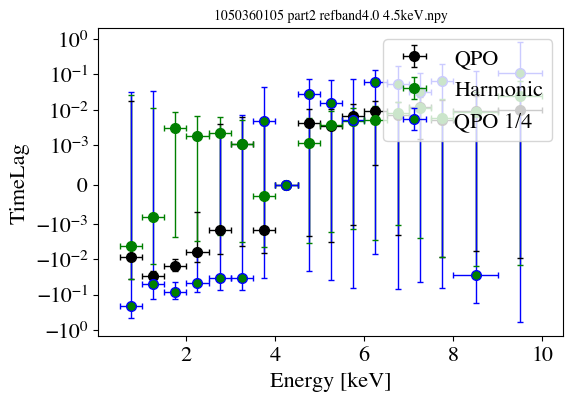

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part0_refband1.5_2.0keV.npy


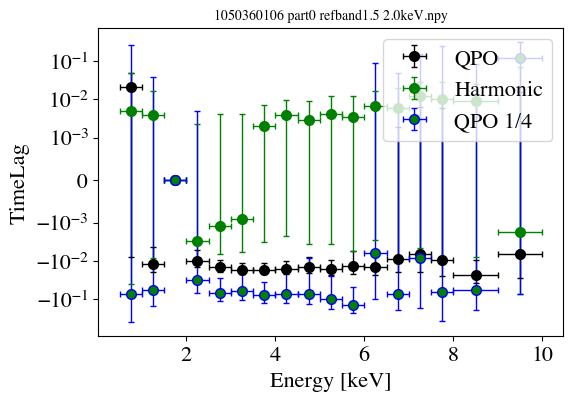

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part0_refband4.0_4.5keV.npy


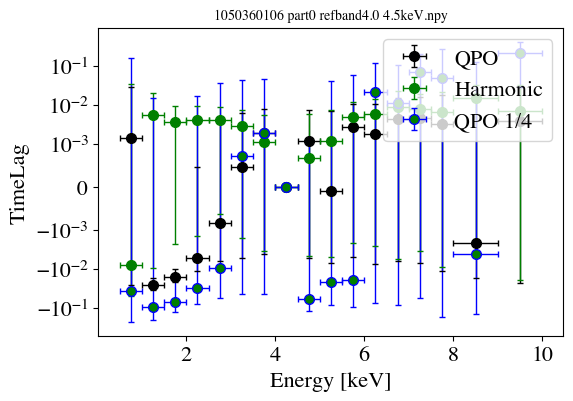

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part1_refband1.5_2.0keV.npy


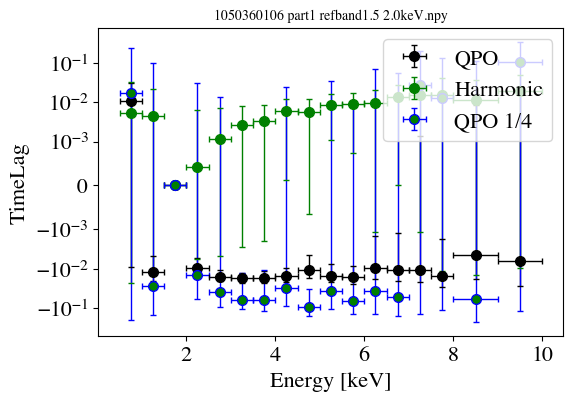

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part1_refband4.0_4.5keV.npy


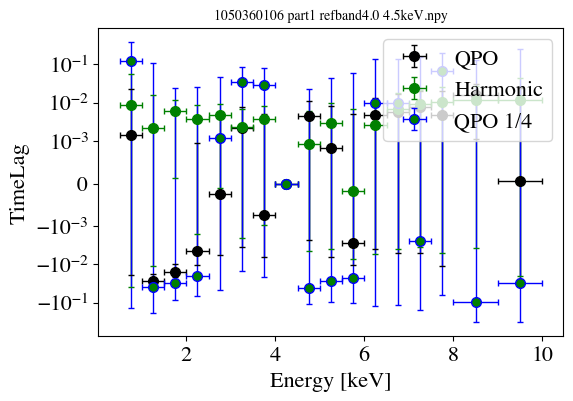

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part2_refband1.5_2.0keV.npy


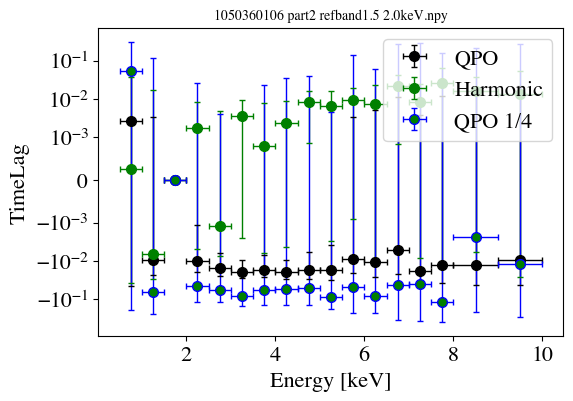

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360106_part2_refband4.0_4.5keV.npy


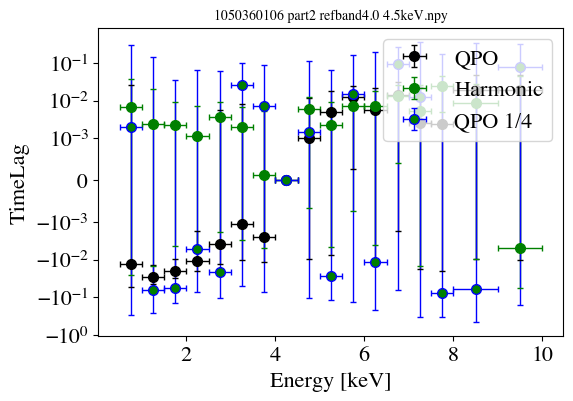

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360107_part0_refband1.5_2.0keV.npy


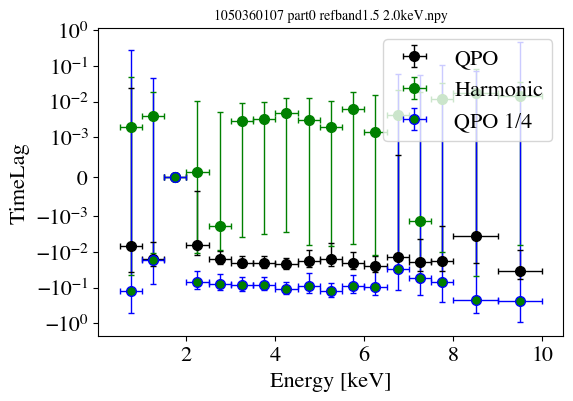

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360107_part0_refband4.0_4.5keV.npy


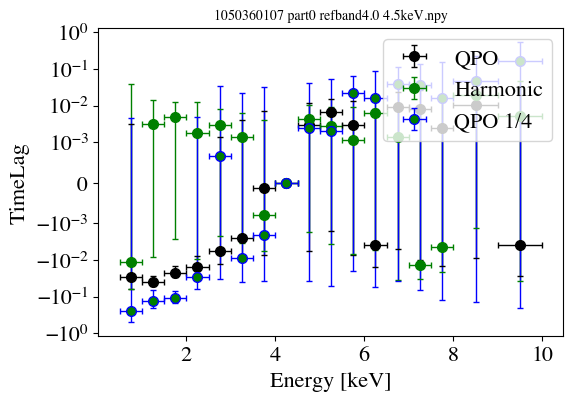

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360109_part1_refband1.5_2.0keV.npy


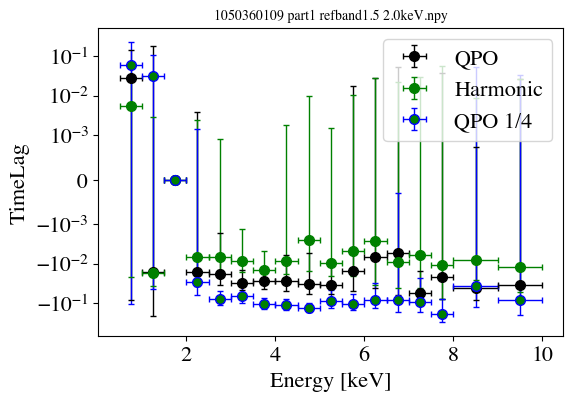

DATA:  Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/1050360109_part1_refband4.0_4.5keV.npy


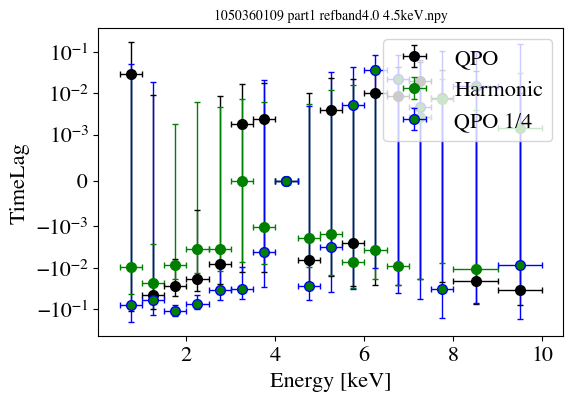

In [98]:
save_path_v = sorted(glob.glob('Data/MAXIJ1535_571/with_nicerl2/TimeLag_vs_Energy/*.npy'))
for s in save_path_v:
    print('DATA: ',s)
    plot_timelag_vs_energy(s)